# Previsioni delle quantità di CO<sub>2</sub> emesse da veicoli

## Caricamento dei dati
Per questo progetto sono stati utilizzati tre dataset differenti. <br>
Quindi sono necessarie tre esplorazioni separate dei dati e un'omogeneizzazione dei dati, al fine di ottenere un unico dataset per l'addestramento. <br>

In [83]:
!pip install pykan

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, ParameterSampler, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, r2_score,
    mean_absolute_error, max_error
)
import sklearn.metrics as metrics
from scipy import stats
import xgboost as xgb

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from kan import *
import random
import inspect
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [85]:
import os.path
from urllib.request import urlretrieve

DATASETS = {
    "car_emissions_spain2022.csv": "https://raw.githubusercontent.com/vMxster/Thesis/main/Datasets/car_emissions_spain2022.csv",
    "car_emissions_canada2014.csv": "https://raw.githubusercontent.com/vMxster/Thesis/main/Datasets/car_emissions_canada2014.csv",
    "car_emissions_uk2013.csv": "https://raw.githubusercontent.com/vMxster/Thesis/main/Datasets/car_emissions_uk2013.csv"
}

for filename, dataset in DATASETS.items():
    if not os.path.exists(filename):
      urlretrieve(dataset, filename)

In [86]:
spain_emissions = pd.read_csv("car_emissions_spain2022.csv")
spain_emissions.head(5)

,id,make,model,market_segment,engine_type,consumption_min_l_100km,consumption_max_l_100km,emissions_min_gCO2_km,emissions_max_gCO2_km,transmission,...,avg_wltp_emissions_gCO2_km,length_mm,width_mm,height_mm,gross_vehicle_weight_rating_kg,total_seating,fuel_economy_index,type_hybrid,electric_consumption_kwh_100km,battery_capacity_kwh
0,551266,AIWAYS,AIWAYS U5 MAS861-WVTA/2WB/FL4,Berlinas-Familiares Medios,Eléctricos puros,NaN,NaN,NaN,NaN,A,...,0.0,4680,1865,1700,2135,5,Sin clasificación,NaN,15.75,63.0
1,579684,AIWAYS,AIWAYS U6 PRIME,Berlinas-Familiares Grandes,Eléctricos puros,NaN,NaN,NaN,NaN,A,...,0.0,4805,1880,1641,2290,5,Sin clasificación,NaN,16.00,63.0
2,464453,ALKE,ALKE ATX 310 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3030,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0
3,464454,ALKE,ALKE ATX 320 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3850,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0
4,464455,ALKE,ALKE ATX 330 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3850,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0


In [87]:
canada_emissions = pd.read_csv("car_emissions_canada2014.csv")
canada_emissions.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1.8,4,A4,X,10.2,7.0,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1.8,4,M5,X,9.6,7.0,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1.8,4,M5,Z,9.4,7.0,8.3,34,191
3,4,1995,Acura,Legend,Compact,3.2,6,A4,Z,12.6,8.9,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3.2,6,A4,Z,13.0,9.3,11.3,25,260


In [88]:
uk_emissions = pd.read_csv("car_emissions_uk2013.csv", low_memory=False)
uk_emissions.head(5)

,file,year,manufacturer,model,description,euro_standard,tax_band,transmission,transmission_type,engine_capacity,...,nox_emissions,thc_nox_emissions,particulates_emissions,fuel_cost_12000_miles,fuel_cost_6000_miles,standard_12_months,standard_6_months,first_year_12_months,first_year_6_months,date_of_change
0,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,618.0,NaN,NaN,NaN,NaN,NaN
1,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN
2,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,Cloverleaf,2,NaN,M5,Manual,1970.0,...,NaN,NaN,NaN,NaN,663.0,NaN,NaN,NaN,NaN,NaN
3,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,626.0,NaN,NaN,NaN,NaN,NaN
4,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN


# **Esplorazione dei singoli dataset**

# Esplorazione del dataset `uk_emissions`

Il dataset in questione è stato reso fruibile dalla Vehicle Certification Agency (VCA) del Department for Transport britannico, al fine di reperire informazioni inerenti a tutte le vetture nuove in vendita nel Regno Unito nel lasso temporale 2000-2013, e quelle usate immatricolate per la prima volta a partire dal 1° marzo 2001. Il termine *nuova* si riferisce ad una qualsiasi automobile allora disponibile per l'acquisto o il leasing presso un concessionario e che non fosse stata precedentemente registrata. Sempre citando la [documentazione](https://www.gov.uk/co2-and-vehicle-tax-tools), abbiamo che entrambi i veicoli nuovi ed usati possono essere cercati per trovarne i corrispondenti:
- Fuel consumption and CO<sub>2</sub> emissions (by make and model)
- vehicle tax information (by make, model, registration date and current tax tables)
- The cost of tax for all vehicle types

Mentre sono disponibili solamente per le macchine nuove le seguenti informazioni:

- Tax band, including Band A (exempt from tax)
- Fuel economy
- Annual fuel running costs
- Company car taxation, based on CO<sub>2</sub> bands
- Alternative fuel types

Potremmo quindi inziare l'analisi del dataset verificando la veridicità di quest'ultimo ragguaglio, ossia controllando che le auto usate assumano valore NaN in corrispondenza delle colonne sopracitate. Sfortunatamente non disponiamo di una variabile che distingua esplicitamente i mezzi nuovi da quelli usati, ma sappiamo che le osservazioni con `date_of_change` (assumendo si riferisca alla data del passaggio di proprietà) diverso da NaN indicano una vettura sicuramente di seconda mano. Quindi sebbene queste rappresentino un sottoinsieme delle usate (mancherebbero quelle usate da un unico proprietario) eseguiamo il test:

In [89]:
used_cars_subset = uk_emissions.loc[~uk_emissions["date_of_change"].isna()]
columns_supposedly_nan = used_cars_subset[["tax_band",
                                           "standard_12_months",
                                           "standard_6_months",
                                           "first_year_12_months",
                                           "first_year_6_months",
                                           "fuel_cost_12000_miles"]]
print(columns_supposedly_nan)
columns_supposedly_nan.isna().all()

      tax_band  standard_12_months  standard_6_months  first_year_12_months  \
6017       NaN                 NaN                NaN                   NaN   
6018       NaN                 NaN                NaN                   NaN   
6019       NaN                 NaN                NaN                   NaN   
6020       NaN                 NaN                NaN                   NaN   
6021       NaN                 NaN                NaN                   NaN   
...        ...                 ...                ...                   ...   
12226      NaN                 NaN                NaN                   NaN   
12227      NaN                 NaN                NaN                   NaN   
12228      NaN                 NaN                NaN                   NaN   
12229      NaN                 NaN                NaN                   NaN   
12230      NaN                 NaN                NaN                   NaN   

       first_year_6_months  fuel_cost_12000_miles  

,0
tax_band,True
standard_12_months,True
standard_6_months,True
first_year_12_months,True
first_year_6_months,True
fuel_cost_12000_miles,True


Abbiamo appurato l'attendibilità della documentazione riguardo al valore degli attributi supposti NaN nelle auto usate. Ci rimane da esaminare l'assenza di tipi di carburante alternativi (contraddistinti dal valore _Petrol/E85(Flex Fuel)_) nella feature categorica `fuel_type` in tali osservazioni:

In [90]:
used_cars_subset["fuel_type"].isin(["Petrol / E85 (Flex Fuel)"]).any()

np.False_

Possiamo ritenerci soddisfatti. Sarebbe ora lecito chiedersi quali siano i marchi automobilistici più popolari nel dataset. Soddisfiamo la nostra curiosità visualizzando i primi dieci in ordine decrescente per numero di comparse in un diagramma a torta, condensando i restanti brand nello spicchio `Others` per motivi di comprensibilità.

[62] different manufacturers and [45511] total cars are registered


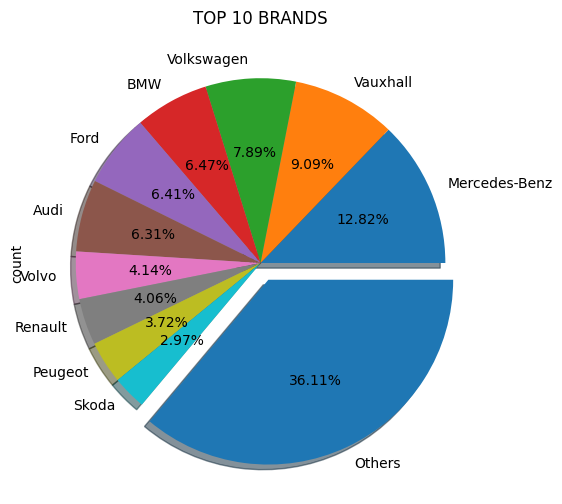

In [91]:
# n.b., i termini "manufacturer" e "brand" sono utilizzati come sinonimi
print("[" + str(uk_emissions["manufacturer"].nunique()) \
      + "] different manufacturers and ["               \
      + str(uk_emissions["manufacturer"].count())       \
      + "] total cars are registered")
manufacturers = uk_emissions["manufacturer"].value_counts()
majority_brands = manufacturers[:10]
minority_brands = manufacturers[10:]
# oppure raggruppando i brand che rappresentano meno del 5%
# minority_brands_perc = manufacturers[manufacturers < uk_emissions["manufacturer"].count() * 5 / 100]
majority_brands["Others"] = minority_brands.sum()
my_explode = np.append(np.zeros(majority_brands.count() - 1), 0.1)
majority_brands.plot.pie(title = "TOP 10 BRANDS", explode = my_explode, shadow = True, autopct = "%.2f%%", figsize=(6, 6));

In [92]:
print("OTHERS: 11th to 62nd brand in descending order of popularity:\n")
percentages = minority_brands.to_numpy() * 100 / uk_emissions["manufacturer"].count()
list_of_series = [minority_brands.index.values, minority_brands.values, percentages]
minority_df = pd.DataFrame({"manufacturer"  : minority_brands.index.values,
                            "# occurrences" : minority_brands.values,
                            "percentage"    : percentages})
n_brands = uk_emissions["manufacturer"].nunique()
minority_df.index = range(11, n_brands + 1)
print(minority_df)

OTHERS: 11th to 62nd brand in descending order of popularity:

            manufacturer  # occurrences  percentage
11                 Honda           1222    2.685065
12               Citroen           1139    2.502692
13                  Saab            902    1.981938
14                Toyota            868    1.907231
15            Mitsubishi            767    1.685307
16                   Kia            721    1.584232
17                  Seat            710    1.560062
18                  Fiat            702    1.542484
19                Nissan            666    1.463382
20               Hyundai            641    1.408451
21                 Mazda            635    1.395267
22         Chrysler Jeep            610    1.340335
23               Porsche            606    1.331546
24                Subaru            577    1.267825
25                Suzuki            531    1.166751
26        MG Rover Group            470    1.032717
27            Alfa Romeo            465    1.021731
2

Vediamo ora all'interno di ciascuno dei brand graficati in precedenza quale sia il modello con più occorrenze registrate, servendoci di un istogramma dove ci cureremo di mantenere l'ordine dei produttori secondo le percentuali dianzi calcolate, per una maggiore leggibilità.

Manufacturers left after screening: [10]


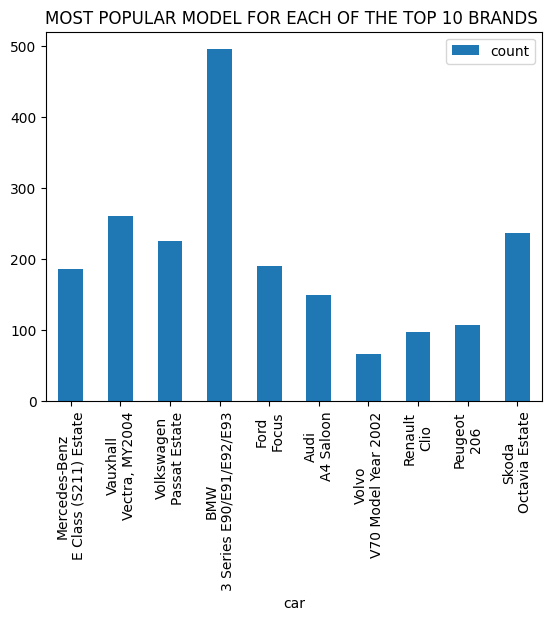

In [93]:
brands_and_models = uk_emissions[["manufacturer", "model"]].copy()
brands_and_models = brands_and_models[brands_and_models.manufacturer.isin(majority_brands.index)]
print("Manufacturers left after screening: [" + str(brands_and_models.manufacturer.nunique()) + "]")
majority_brands = majority_brands.drop("Others")
brands_and_models = brands_and_models.value_counts(["manufacturer", "model"]) \
        .reset_index(name = "count")                                          \
        .sort_values(["count"], ascending = False)                            \
        .drop_duplicates(["manufacturer"])                                    \
        .set_index(["manufacturer"])                                          \
        .reindex(majority_brands.index) # ri-ordiniamo secondo la classifica dei brand stilata in precedenza
brands_and_models["car"] = brands_and_models.index + "\n" + brands_and_models["model"] # concateniamo le stringhe
brands_and_models.plot.bar(title = "MOST POPULAR MODEL FOR EACH OF THE TOP 10 BRANDS ", x = "car", y = "count");

Rimarcherei come un marchio automobilistico possa ripetersi più volte nel dataframe per via degli ipotetici diversi modelli ad esso associati, mentre le molteplici apparizioni di uno stesso modello sono giustificate da una o più differenze di valori in variabili attinenti a specifiche tecniche quali la `engine_capacity` o il `fuel_type`. Potremmo infatti trovare, e.g., una _Ford Courier_ sia a benzina (petrol) con cilindrata (engine_capacity) di 1299 cm<sup>3</sup> che a diesel con cilndrata di 1753 cm<sup>3</sup>. Andiamo ad estrarre qualche insight, facendo attenzione a non assumere che non vi possano essere modelli omonimi tra brand diversi (contando quindi i valori unici in coppia con il relativo brand). Di seguito ignoreremo le le differenze di trasmissione.

In [94]:
n_cars = len(uk_emissions[["manufacturer", "model", "description"]].copy().drop_duplicates())
n_models = len(uk_emissions[["manufacturer", "model"]].copy().drop_duplicates())
n_brands = len(uk_emissions[["manufacturer"]].copy().drop_duplicates())
print("Average number of engine variants per model: [{:.2f}]".format(n_cars / n_models))
print("Average number of models per manufacturer:  [{:.2f}]".format(n_models / n_brands))

Average number of engine variants per model: [9.85]
Average number of models per manufacturer:  [43.05]


Indaghiamo la relazione tra la classi dello [Standard europeo sulle emissioni inquinanti](https://en.wikipedia.org/wiki/European_emission_standards) e lo sprigionamento di CO delle vetture, per mezzo di un diagramma a scatola e baffi. Osserviamo come le medie dei box siano ordinate. La presenza di outliers, assieme al fatto che uno stesso range di valori di monossido di carbonio possa appartenere a più classi, sono chiari indicatori di come il CO non sia, ragionevolmente, l'unico inquinante tenuto in considerazione per determinare l'appartenenza ad una certa categoria `euro_standard`. Com'è infatti possibile verificare nella pagina a cui rinvia l'hyperlink, THC, NMHC, NH<sub>3</sub> e NO<sub>x</sub> sono alcuni tra gli altri composti valutati.

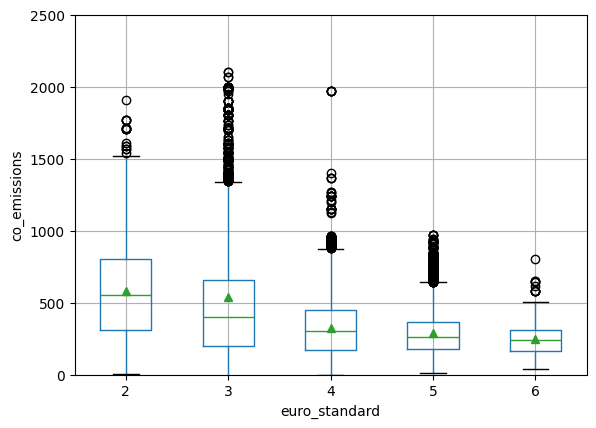

In [95]:
quartiles_first = uk_emissions.boxplot(column = "co_emissions", by = "euro_standard", showmeans = True);
quartiles_first.set_ylabel("co_emissions");
quartiles_first.set_title("");
plt.ylim(0, 2500);
plt.suptitle("");

Similmente a quanto fatto sopra andiamo, attraverso un diagramma degli estremi e dei quartili, ad analizzare l'eventuale legame tra `tax_band` e `co2_emissions`. Questa volta notiamo tuttavia come il valore massimo di diossido di carbonio (in g/km) di una certa fascia corrisponda al minimo di quella successiva. In effetti, come riportato nella [guida](https://assets.publishing.service.gov.uk/media/6603f64b13397a0011e419be/v149-rates-of-vehicle-tax-for-cars-motorcycles-light-goods-vehicles-and-private-light-goods-vehicles.pdf) redatta dalla Driver and Vehicle Licensing Agency (DVLA), la CO<sub>2</sub> risulterebbe essere, assieme al `fuel_type`, l'unico elemento considerato nel decretare gli scaglioni di tasse.

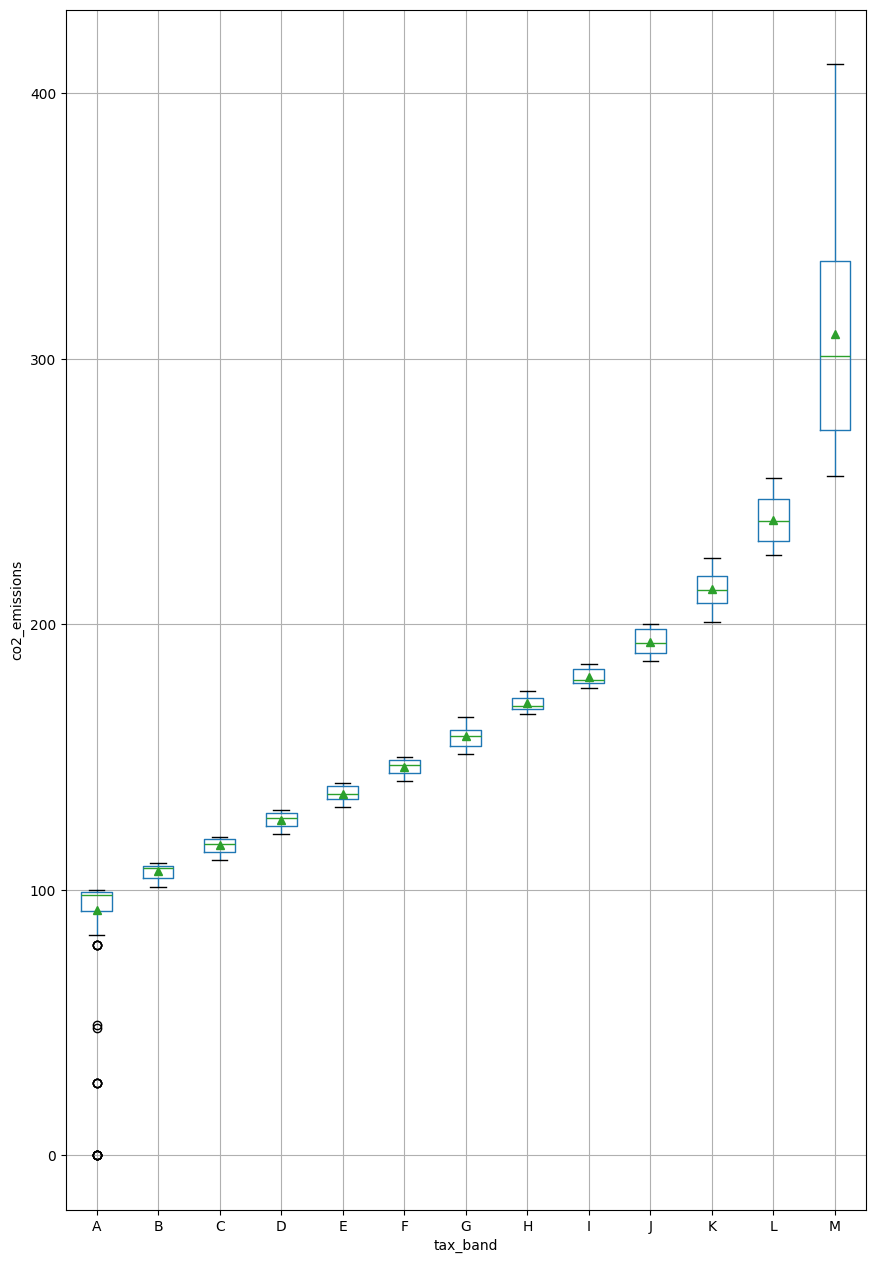

In [96]:
quartiles_second = uk_emissions.boxplot(column = "co2", by = "tax_band", showmeans=True, figsize = (10, 16));
quartiles_second.set_ylabel("co2_emissions");
quartiles_second.set_title("");
plt.suptitle("");

Concludiamo l'esplorazione di questo dataset con un grafico a dispersione che leghi l'`engine_capacity` (volume del motore in cm<sup>3</sup>) di ciascuna vettura con i relativi `combined_metric` (consumi in l/100km). Come ci aspettavamo, in linea di massima, al crescere del primo aumenta anche il secondo ed il trend potrebbe, come suggerisce anche l'indice di correlazione di Pearson tra le due colonne, essere approssimato in maniera soddisfacente da una retta.

Pearson correlation coefficient: [0.77]


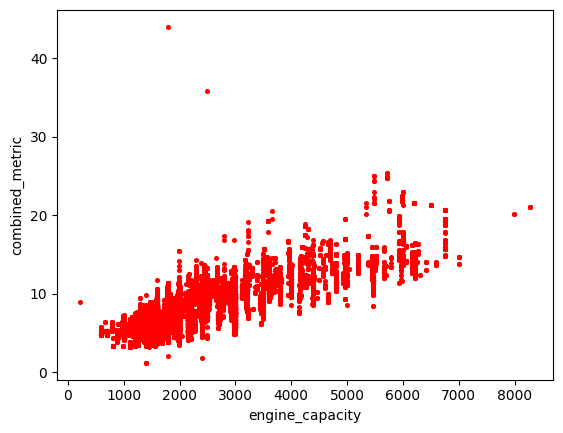

In [97]:
uk_emissions.plot.scatter("engine_capacity", "combined_metric", s=7, c="red");
print("Pearson correlation coefficient: [{:.2f}]".format(uk_emissions["engine_capacity"].corr(uk_emissions["combined_metric"])))

# Esplorazione del dataset `spain_emissions`
### Rimozione delle righe riguardanti veicoli elettrici

All'interno del dataset proveniente dal ministero spagnolo sono presenti anche dati riguardanti macchine elettriche. Questa tipologia di dato non è interessante per l'obiettivo del modello, ovvero la quantità di CO<sub>2</sub> emessa.

La cella seguente analizza i valori delle righe che hanno `engine_type` "Eléctricos puros", estraendo solo le colonne sul minimo e massimo di consumo di litri di carburante e sul minimo e massimo di emissioni di CO<sub>2</sub> per km percorso.

In [98]:
columns = ["emissions_min_gCO2_km", "emissions_max_gCO2_km"]
spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros", columns].isna().all()

,0
emissions_min_gCO2_km,True
emissions_max_gCO2_km,True


Come era previdibile, tutti i valori delle emissioni di CO<sub>2</sub> per km nelle righe riguardanti i veicoli elettrici sono mancanti, quindi le rispettive righe possono essere eliminate, poichè non utili per l'addestramento del modello, il cui obiettivo è la previsione dell'emissione di CO<sub>2</sub> per veicoli a motore termico.

In [99]:
electric_cars_index = spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros"].index
spain_emissions = spain_emissions.drop(electric_cars_index)
spain_emissions["engine_type"].unique()

array(['Gasolina', 'Gasóleo', 'Híbridos enchufables',
       'Híbridos de gasolina', 'Gas natural', 'Híbridos de gasóleo',
       'Gases licuados del petróleo (GLP)', 'Pila de combustible',
       'Autonomía extendida'], dtype=object)


Come si può notare dall'output della cella precedente, la colonna `engine_type` non contiene il valore "Eléctricos puros".

### Rimozione delle colonne contenenti solo valori `NaN`
Nel dataset dell'emissioni di CO<sub>2</sub> proveniente dalla Spagna la colonne `type_hybrid`, `electric_consumption_kwh_100km`, `battery_capacity_kwh ` contengono solo valori `NaN`.

In [100]:
all_nan_columns = ["type_hybrid", "electric_consumption_kwh_100km", "battery_capacity_kwh"]
spain_emissions[all_nan_columns].isna().values.all()

np.True_

In [101]:
spain_emissions = spain_emissions.drop(all_nan_columns, axis=1)

### Rimozione delle righe senza un valore valido di trasmissione
La colonna `transmission` contiene il tipo di trasmissione del veicolo, quindi la modalità di cambio della marcia, se automatica o manuale, che nella colonna sono rispettivamente "A" e "M". L'output della prossima cella mostra che sono presenti 35 righe con valori di trasmissioni non validi, poichè nel dataset spagnolo "SC" sta per "Sin clasificasion", ovvero non classificato. Perciò le righe con valori di trasmissione non validi, essendo un numero molto ridotto, verrano eliminate.

In [102]:
spain_emissions["transmission"].value_counts()

,count
transmission,
A,7735
M,7337
SC,33
0,2


In [103]:
valid_transmissions = spain_emissions["transmission"].isin(["A", "M"])
spain_emissions["transmission"] =  spain_emissions.loc[valid_transmissions, "transmission"]

# Esplorazione del dataset `canada_emissions`

### Gestione dimensioni motore

All'interno del dataset proveniente dal ministero canadese sono presenti le dimensioni in L (Litri) del motore dei vari veicoli. Decidiamo di trasformarle in cm$^3$ rinominando quindi la feature Engine_cm3.

In [104]:
canada_emissions = canada_emissions.rename(columns={"Engine size (L)": "Engine_cm3"})
canada_emissions["Engine_cm3"] = canada_emissions["Engine_cm3"] * 1000
canada_emissions.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine_cm3,Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1800.0,4,A4,X,10.2,7.0,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1800.0,4,M5,X,9.6,7.0,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1800.0,4,M5,Z,9.4,7.0,8.3,34,191
3,4,1995,Acura,Legend,Compact,3200.0,6,A4,Z,12.6,8.9,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3200.0,6,A4,Z,13.0,9.3,11.3,25,260


### Trattamento valori mancanti

Con la cella seguente verifico se il dataset contiene dei dati mancanti (nan).

In [105]:
canada_emissions.isna().values.any()

np.False_

Visto che il risultato è false non c'è alcun valore mancante da gestire.

### Grafici
Questa sezione contiene alcuni grafici che evidenziano alcuni aspetti del dataframe `canada_emissions`.

L'istogramma seguente mostra la distribuzione delle emissioni di CO$_2$ nel dataframe canadese. I valori si concentrano principalmente nell'intervallo [150,350].

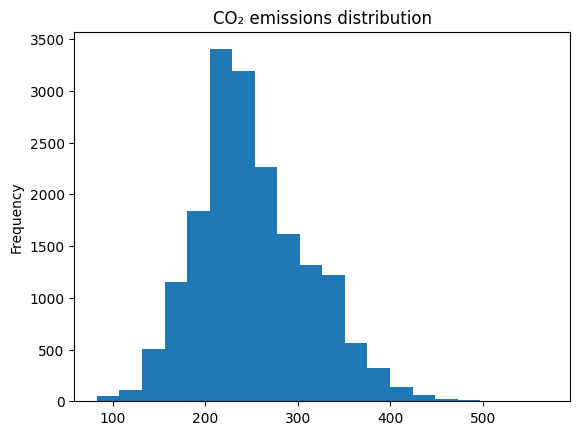

In [106]:
canada_emissions["CO2 emissions (g/km)"].plot.hist(bins=20,title="CO\u2082 emissions distribution");

L'istogramma seguente mostra le dimensioni dei motori dei vari veicoli nel dataframe canadese. I valori si concentrano principalmente nell'intervallo [1500,6000].

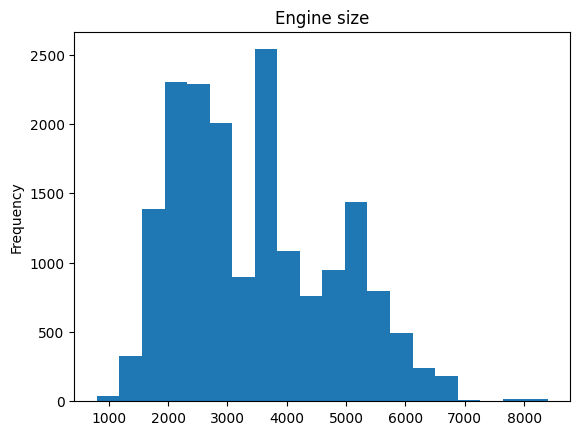

In [107]:
canada_emissions["Engine_cm3"].plot.hist(bins=20,title="Engine size");

Il seguente grafico a torta mostra il numero di cilindri (in percentuale) dei vari veicoli nel dataframe canadese. La maggior parte di essi ha 6 cilindri.

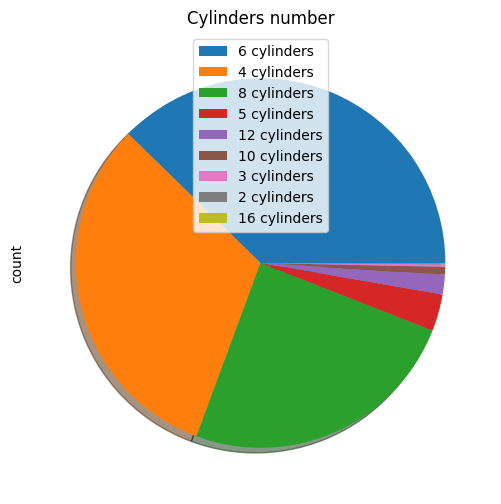

In [108]:
canada_emissions["Cylinders"].value_counts().plot.pie(title="Cylinders number" , shadow=True, figsize=(6,6), labels=None)
labels = [str(cylinder) + " cylinders" for cylinder in canada_emissions["Cylinders"].value_counts().index]
plt.legend(labels);

Il seguente grafico a barre mostra i vari tipi di veicoli presenti nel dataset canadese con la relativa frequenza.

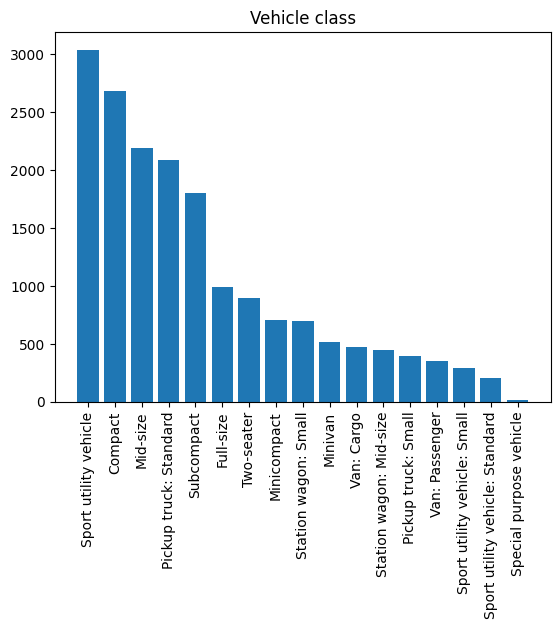

In [109]:
canada_vehicle_class = canada_emissions["Vehicle class"].value_counts()
plt.bar(canada_vehicle_class.index, canada_vehicle_class.values)
plt.xticks(rotation='vertical')
plt.title("Vehicle class")
plt.show()

# **Omogeneizzazione ed unione dei dati**
Avendo reperito tre set di dati ciascuno da una fonte differente, sebbene questi concernano il medesimo dominio e condividano pertanto una considerevole quantità di attributi, potremmo essere erroneamente portati a compiere un troncamento delle colonne, conservando esclusivamente quelle appartenenti all'intersezione delle tre tabelle, tuttavia così facendo andremmo a trascurare il caso-limite in cui le features eliminate dovessero essere le uniche legate, attraverso un relazione non randomica, a quella indagata. Una soluzione più scrupolosa consisterebbe, al contrario, nell'**unione** degli **attributi**, colmando opportunamente le celle vuote formatesi. In effetti, come visto a lezione, i valori NAN possono essere sostituiti, tra gli altri, da (a seconda che le colonne siano di tipo categorico o numerico):
- media
- moda
- mediana

Questo ragionamento va ad ogni modo applicato nei limiti del ragionevole: se una variabile dovesse essere presente solamente in uno dei tre dataset, sarebbe piuttosto fuorviante "inventare" i 2/3  dei valori da essa assunti (ipotizzando i dataset di egual dimensione). Decidiamo quindi di mantenere le colonne presenti in almeno due dataset su tre. In aggiunta, le stesse variabili in comune, malgrado facciano riferimento allo stesso concetto, si manifestano saltuariamente sotto denominazioni diverse, ed a loro volta i valori da queste assunti potrebbero avere formato dissimile (e.g. capitalizzazione delle lettere nel caso testuale o numero di cifre significative in quello numerico).







## Omogeneizzazione di `uk_emissions`

Rimuoviamo le colonne proprie di questo dataset, per moderare la presenza di NaN o dati sostitutivi in quello risultante dall'unione:

In [110]:
uk_emissions = uk_emissions.drop(columns = ["file", "description", "euro_standard", "tax_band", "transmission", "urban_metric",
                                            "extra_urban_metric", "urban_imperial", "extra_urban_imperial", "combined_imperial",
                                            "noise_level", "thc_emissions", "co_emissions", "nox_emissions", "thc_nox_emissions",
                                            "particulates_emissions", "fuel_cost_12000_miles", "fuel_cost_6000_miles", "standard_12_months",
                                            "standard_6_months", "first_year_12_months", "first_year_6_months", "date_of_change"])

Trasformiamo i nomi delle variabili in quelli concordati con gli altri componenti del gruppo:

In [111]:
uk_emissions.columns = uk_emissions.columns.str.capitalize()
uk_emissions.rename(columns = {"Engine_capacity" : "Engine_cm3",
                               "Combined_metric" : "Fuel_consumption",
                               "Co2" : "CO2_Emissions"}, inplace = True)

Ci troviamo ora dinnanzi ad una delle principali complicazioni indotte dall'utilizzo di più dataset. L'obbiettivo sarebbe quello di manipolare i nomi delle vetture in modo tale da garantire la consistenza semantica del dataset finale: non vorremmo che, e.g., le automobili _BMW 3 Series_ e _Bmw Series 3_ siano considerate differenti, perlomeno sugli attributi `Manufacturer`e `Model`, anche per consentire all'algoritmo di machine learning di trarre conclusioni rispetto al modello specifico. Il problema non si pone per variabili numeriche come i consumi o la cilindrata, dove siamo interessati più al range di appartenenza piuttosto che ai valori precisi. Vista la mancanza di un pattern universale e siccome risulterebbe eccessivamente gravoso indagare tutte le ~90'000 osservazioni, ci limiteremo ad uniformare quantomeno un campione di automobili analizzato.

In [112]:
uk_emissions.dropna(inplace = True)
uk_emissions["Model"] = uk_emissions["Model"].replace("[\(\[].*?[\)\]]", "", regex = True)
uk_emissions["Model"] = uk_emissions.apply(lambda row : row["Model"].replace(str(row["Manufacturer"]), ''), axis=1)
uk_emissions["Model"] = uk_emissions["Model"].str.split(" ").str[0].str.replace(",", "")
uk_emissions

,Year,Manufacturer,Model,Transmission_type,Engine_cm3,Fuel_type,Fuel_consumption,CO2_Emissions
0,2000,Alfa Romeo,145,Manual,1598.0,Petrol,8.2,195
1,2000,Alfa Romeo,145,Manual,1747.0,Petrol,8.4,200
2,2000,Alfa Romeo,145,Manual,1970.0,Petrol,8.8,210
3,2000,Alfa Romeo,146,Manual,1598.0,Petrol,8.3,195
4,2000,Alfa Romeo,146,Manual,1747.0,Petrol,8.4,200
...,...,...,...,...,...,...,...,...
45173,2013,Volvo,XC70,Automatic,2400.0,Diesel,6.4,169
45174,2013,Volvo,XC70,Automatic,2953.0,Petrol,10.6,248
45175,2013,Volvo,XC90,Automatic,2400.0,Diesel,8.3,219
45176,2013,Volvo,XC90,Automatic,2400.0,Diesel,8.2,215


## Omogeneizzazione di `spain_emissions`

### Traduzione spagnolo-inglese
Il dataset proveniente dalla Spagna contiene due colonne in spagnolo, `engine_type` e `market_segment`. Quindi è necessaria una traduzione dallo spagnolo all'inglese per entrambe le colonne, così da adattarle agli altri due dataset.

Definisco una funzione per sostituire i valori di una colonna di un dataframe con dei nuovi valori passati come argomento, in questo caso la rispettiva traduzione in inglese, tramite una funzione di mapping fornita da pandas.

In [113]:
def get_column_mapped_values(column, new_values):
    mapping = dict(zip(column.unique(), new_values))
    return column.map(mapping)

In [114]:
#Traduzione della colonna engine_type
spanish_engine_type = spain_emissions["engine_type"].unique()
english_engine_type = ["Petrol", "Diesel", "Plug-in hybrid", "Petrol hybrid", "Natural gas",
                       "Diesel Hybrid", "Liquefied petroleum gas(LPG)", "Fuel cell", "Extended range"]

spain_emissions["engine_type"] = get_column_mapped_values(spain_emissions["engine_type"], english_engine_type)

Per la traduzione della colonna `market_segment` si fa riferimento al dataset canadese, il quale contiene una colonna per la classificazione dei veicoli, `Vehicle class`.


In [115]:
canada_emissions["Vehicle class"].unique()

array(['Subcompact', 'Compact', 'Two-seater', 'Station wagon: Small',
       'Minicompact', 'Mid-size', 'Full-size', 'Station wagon: Mid-size',
       'Van: Cargo', 'Van: Passenger', 'Pickup truck: Standard',
       'Sport utility vehicle', 'Minivan', 'Pickup truck: Small',
       'Special purpose vehicle', 'Sport utility vehicle: Small',
       'Sport utility vehicle: Standard'], dtype=object)

In [116]:
#Traduzione della colonna market_segment
english_market_segment = ["Minicompact", "Compact", "Small off-road", "Mid-size", "Sport utility vehicle", "Full-size",
                          "Mid-size off-road", "Full-size off-road", "Minivan", "Luxury", "Minivan", "Van: Passenger"] \
                        + (["Van: Cargo"] * 2) + (["Lorry"] * 7)

spain_emissions["market_segment"] = get_column_mapped_values(spain_emissions["market_segment"], english_market_segment)

### Calcolo medie del consumo di carburante e delle emissioni di CO<sub>2</sub>
Sia per il consumo di carburante che per le emissioni di CO<sub>2</sub> sono presenti i valori di minimo, di massimo e la media
WLTP (<i>Worldwide harmonized Light vehicles Test Procedure</i>), ovvero le misure ottenute dal test standard a livello mondiale per il controllo delle emissioni e dei consumi dei veicoli.
Da questi tre valori ne verrà calcolata la media così da avere una sola colonna per i consumi di carburante e una sola colonna per i consumi di CO<sub>2</sub>, la variabile target da predire.

Prima di poter precedere è necessario controllare che in tutte le righe del dataframe sia presente almeno uno dei tre valori richiesti e che sia diverso da 0, sia per calcolare la media del consumo che delle emissioni.
<br>Nella cella successiva si può vedere esattamente in quante righe sono mancanti questi valori necessari.

In [117]:
def isnaOrIsZero(dataframe):
    return dataframe.isna() | dataframe.eq(0)

In [118]:
consumption_columns = ["consumption_min_l_100km", "consumption_max_l_100km", "avg_wltp_consumption_l_100km"]
emissions_columns = ["emissions_min_gCO2_km", "emissions_max_gCO2_km", "avg_wltp_emissions_gCO2_km"]

rows_no_consumption = isnaOrIsZero(spain_emissions[consumption_columns]).all(axis=1)
number_rows_missing_consumption = rows_no_consumption.sum()
print("Rows with no consumption_l_100km:", number_rows_missing_consumption)

rows_no_emissions = isnaOrIsZero(spain_emissions[emissions_columns]).all(axis=1)
number_rows_missing_emissions = rows_no_emissions.sum()
print("Rows with no emissions_gCO2_km:", number_rows_missing_emissions)

rows_no_emissions_consumptions = (rows_no_consumption & rows_no_emissions)
number_rows_missing_emissions_consumptions = rows_no_emissions_consumptions.sum()
print("Rows with no emissions_gCO2_km and no consumption_l_km:", number_rows_missing_emissions_consumptions)

Rows with no consumption_l_100km: 1560
Rows with no emissions_gCO2_km: 1562
Rows with no emissions_gCO2_km and no consumption_l_km: 1560


Come riportato nell'output della cella precedente, ci sono <strong>1560</strong> righe senza alcun valore di consumo di carburante, <strong>1562</strong> righe senza alcun valore di emissioni di CO<sub>2</sub> e <strong>1560</strong> in cui è assente sia il consumo di carburante che le emissioni di CO<sub>2</sub>. <br>
Nella cella successiva vengono calcolate le medie di carburante ed emissioni di ciascuna riga e vengono inserite in due nuove colonne `consumption_l_100km`, `emissions_gCO2_km`. <br>

In [119]:
mean_consumption = "consumption_l_100km"
mean_emissions = "emissions_gCO2_km"
spain_emissions[mean_consumption] = spain_emissions[consumption_columns].mean(axis=1)
spain_emissions[mean_emissions] = spain_emissions[emissions_columns].mean(axis=1)

In [120]:
spain_emissions = spain_emissions.drop(consumption_columns + emissions_columns, axis=1)

Quindi vengono sostituiti i valori mancanti e i valori posti a 0, poichè considerati anch'essi mancanti, siccome le categorie di veicoli considerate dovrebbero presentare dei consumi di carburante e delle emissioni di CO<sub>2</sub> positivi. <br>
La cella successiva mostra le categorie di veicoli in cui sono assenti sia i consumi di carburante che le emissioni. Le due categorie con più occorrenze sono i "Van: Cargo" e "Lorry", due mezzi molto pesanti e con valori differenti rispetto ad altre categorie, quindi sarebbe più corretto riempire i valori assenti o posti a 0, con i mediani delle due rispettive categorie. Mentre per le restanti categorie si può utilizzare direttamente il mediano di tutta la colonna.

In [121]:
most_missing_market_segments = spain_emissions.loc[rows_no_emissions_consumptions, "market_segment"].value_counts()[:5]
most_missing_market_segments

,count
market_segment,
Van: Cargo,1202
Lorry,327
Luxury,15
Full-size off-road,9
Van: Passenger,3


Le celle successive evidenziano la necessità di usare, come valore per riempire i valori NaN o posti a 0 delle categorie di veicoli "Van: Cargo" e "Lorry", i rispettivi mediani, anzichè usare direttamente il mediano di tutta la colonna, vista l'ampia differenza causata dalla presenza di veicoli di diverse dimensioni e consumi.

In [122]:
columns = [mean_consumption, mean_emissions]
market_segments = ["Van: Cargo", "Lorry"]

In [123]:
all_median = pd.DataFrame(spain_emissions[columns].median(), columns = ["All"]).T
van_cargo_lorries = spain_emissions.loc[spain_emissions["market_segment"].isin(market_segments), ["market_segment"] + columns]
van_cargo_lorries_median = van_cargo_lorries[van_cargo_lorries.ne(0)].groupby("market_segment").median()

In [124]:
pd.concat([all_median, van_cargo_lorries_median]).style.set_caption("Market segments medians")

,consumption_l_100km,emissions_gCO2_km
All,6.000000,141.000000
Lorry,7.900000,203.333333
Van: Cargo,7.950000,196.083333


In [125]:
def fillnaZeroes(market_segment, columns):
    vehicles = spain_emissions.loc[spain_emissions["market_segment"] == market_segment, columns].replace(0, np.nan)
    vehicles = vehicles.fillna(vehicles.median())
    return vehicles

In [126]:
for market_segment in market_segments:
    spain_emissions.loc[spain_emissions["market_segment"] == market_segment, columns] = fillnaZeroes(market_segment, columns)

In [127]:
other_market_segments = set(spain_emissions["market_segment"].unique()) - set(market_segments)
spain_emissions[columns] = spain_emissions[columns].replace(0, np.nan).fillna(spain_emissions[columns].median())

### Utilizzo di valori espliciti per il tipo di trasmissione
Il dataset spagnolo per indicare la tipologia di trasmissione utilizza solamente "A" e "M". Per adattarlo agli altri dataset e per renderlo più chiaro si è deciso di mappare i rispettivi valori con la versione estesa, ovvero "Automatic", "Manual".

In [128]:
renaming_dict = {"A": "Automatic", "M": "Manual"}
spain_emissions["transmission"] = spain_emissions["transmission"].map(renaming_dict)

### Inserimento dell'anno del modello del veicolo
I dataset canadesi e britannici presentano entrambi una colonna per l'anno del modello(`Model year` in `canada_emissions` e `year` in `uk_emissions`), una feature che può essere importante per la predezioni delle emissioni prodotte. Quindi a partire dagli altri due dataset, viene estratta la colonna dell'anno.

Prima di procedere all'inserimento è necessario un adattamento della colonna `model`, poichè nel dataset `spain_emissions` ciascun valore è formato dal nome della casa automobilistica, ovvero il valore della colonna `make`, dal nome effettivo del modello e da altre informazioni aggiuntive sul modello. Quindi, si procede all'eliminazione della casa automobilistica e delle informazioni aggiuntive per adattarlo alla colonna del modello degli altri due dataset.

La prossime due celle rimuovono suffissi non presenti negli altri due dataset, eliminando le parole contenute nella variabile locale `useless_words`.

In [129]:
useless_words = {"Canarias", "Vehículos", "Turismos", "Comerciales", "Nuevo", "NUEVO", "Turismos"}
# Per rimuovere suffissi fuorvianti, non presenti negli altri dataset, nei nomi delle case automobilistiche
def remove_useless_suffix(make):
    make_words = make.split()
    make_words = set(make_words) - useless_words
    return " ".join(make_words)

In [130]:
spain_emissions["make"] = spain_emissions["make"].apply(remove_useless_suffix)

Di seguito, l'adattamento del nome del modello eliminando la casa automobilistica e le informazioni aggiuntive.

In [131]:
# Per rimuovere il nome della casa automobilistica e le informazioni aggiuntive dal nome del modello
def remove_manufacturer_and_addional_info(make_model):
    make = make_model["make"]
    model = make_model["model"]
    removedManufacturer = model.replace(make, "").split()
    model = [word for word in removedManufacturer if word not in useless_words][0]
    return model

In [132]:
spain_emissions["model"] = spain_emissions[["make", "model"]].apply(remove_manufacturer_and_addional_info, axis=1)

Dopo l'adattamento del nome della casa automobilistica e del nome del modello del veicolo, si può procedere all'effettivo inserimento dell'anno in base ai valori dell'anno nei dataset `uk_emissions` e `canada_emissions`. I valori dell'anno che risultano non presenti a seguito del join con `uk_emissions` verranno prelevati dal secondo dataset `canada_emissions`. In caso dei valori risultassero ancora mancanti, tali righe verranno scartate dal dataset, poichè prive di un'informazione rilevante ai fini dell'addestramento del modello.

In [133]:
spain_emissions = (
    pd.merge(
        spain_emissions,
        uk_emissions[["Manufacturer", "Model", "Year"]],
        how = "left",
        left_on = ["make", "model"],
        right_on =  ["Manufacturer", "Model"]
    )
    .drop_duplicates()
)[list(spain_emissions.columns) + ["Year"]]

In [134]:
spain_emissions_year_na = spain_emissions[spain_emissions["Year"].isna()].drop("Year", axis=1)
spain_emissions_year_canada = (
    pd.merge(
        spain_emissions_year_na,
        canada_emissions[["Make", "Model", "Model year"]],
        how = "left",
        left_on = ["make", "model"],
        right_on =  ["Make", "Model"]
    )
    .drop_duplicates()
    .rename(columns = {"Model year": "Year"})
)[list(spain_emissions.columns)]

La cella a seguire inserisce i valori dell'anno ottenuti dal join con `canada_emissions` al posto dei valori mancanti a seguito del join con `uk_emissions`. Infine, le righe in cui la colonna `year` risulta ancora mancante dopo i due join verranno scartate.   

In [135]:
spain_emissions["Year"] = spain_emissions["Year"].fillna(spain_emissions_year_canada["Year"])
spain_emissions = spain_emissions.dropna()

### Grafici di `spain_emissions`
Questa sezione contiene alcuni grafici che evidenziano alcuni aspetti del dataframe risultante `spain_emissions`.value_countsunique

L'istogramma seguente mostra la distribuzione delle emissioni di CO<sub>2</sub> nel dataset spagnolo. I valori si concentrano principalmente nell'intervallo [100, 200].

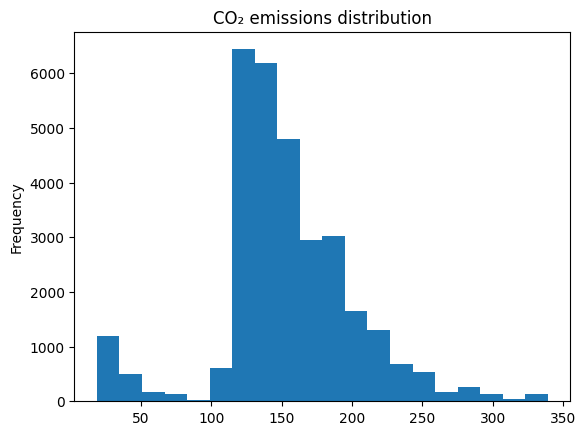

In [136]:
spain_emissions["emissions_gCO2_km"].plot.hist(bins=20,title="CO\u2082 emissions distribution");

Il seguente grafico mostra la correlazione tra il consumo di carburante e le emissioni di CO<sub>2</sub>. Si evince che esiste una dipendenza tra i due valori, fatta eccezione per alcuni punti.

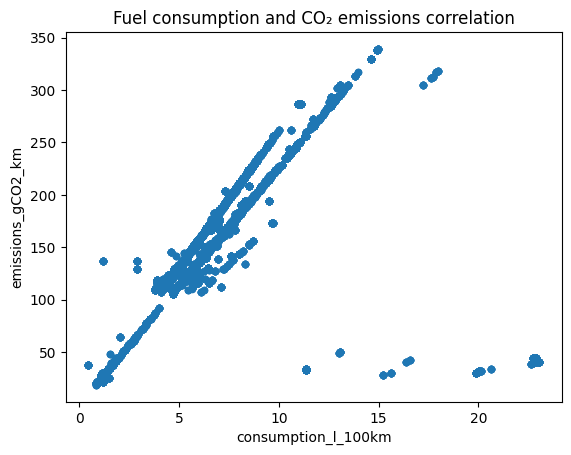

In [137]:
spain_emissions.plot.scatter("consumption_l_100km", "emissions_gCO2_km", title="Fuel consumption and CO\u2082 emissions correlation");

Nel grafico a torta è rappresentata la distribuzione delle categorie di veicoli. Una metà è occupata da sole 4 categorie, mentre le altre 8 si spartiscono il restante 50%.

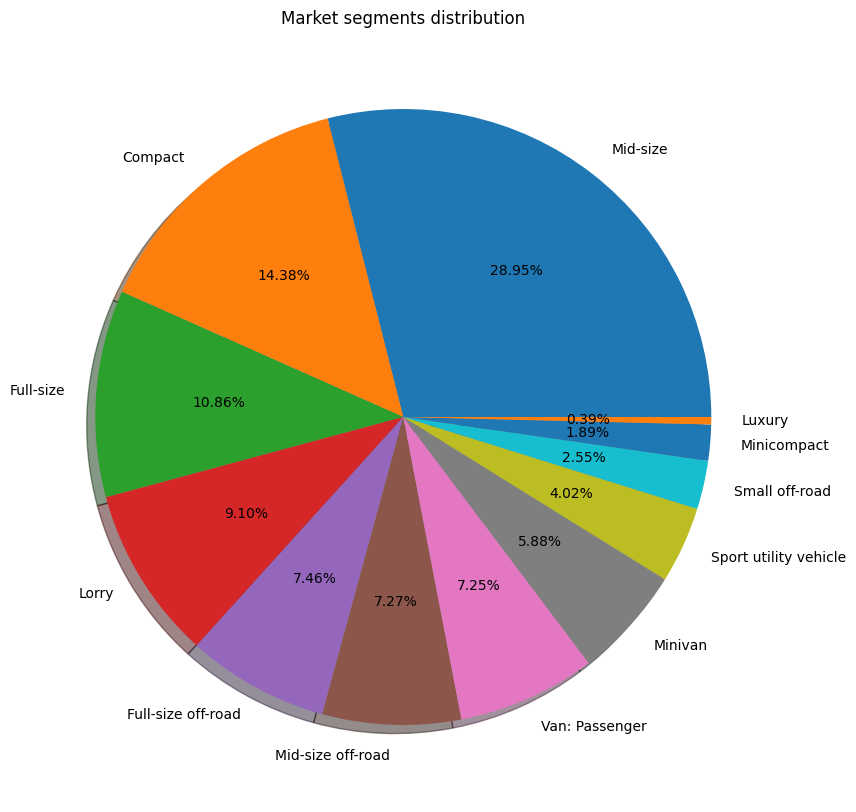

In [138]:
spain_emissions["market_segment"].value_counts()[:-1].plot.pie(autopct="%.2f%%", title="Market segments distribution", shadow=True, label="", figsize=(10,10));

Nel seguente grafico è mostrata la relazione tra ciascuna categoria di veicoli e le emissioni di CO<sub>2</sub> corrispondenti. Sono presenti molti outlier sia nella parte inferiore che nella parte superiore di ciascun boxplot. Si può notare come i le medie dei valori di veicoli più pesanti e più inquinanti come "Lorry", "Van: Cargo" e "Luxury" siano molto più alti delle medie dei valori corrispondenti ai veicoli più leggeri e meno inquinanti come "Compact", "Minicompact" e "Mid-size". Questa osservazione è vera solo per le medie e i mediani, siccome i valori di ciascun boxplot coprono una buona parte dell'asse y, quindi alcuni veicoli "Compact" hanno valori più alti di alcuni "Lorry".

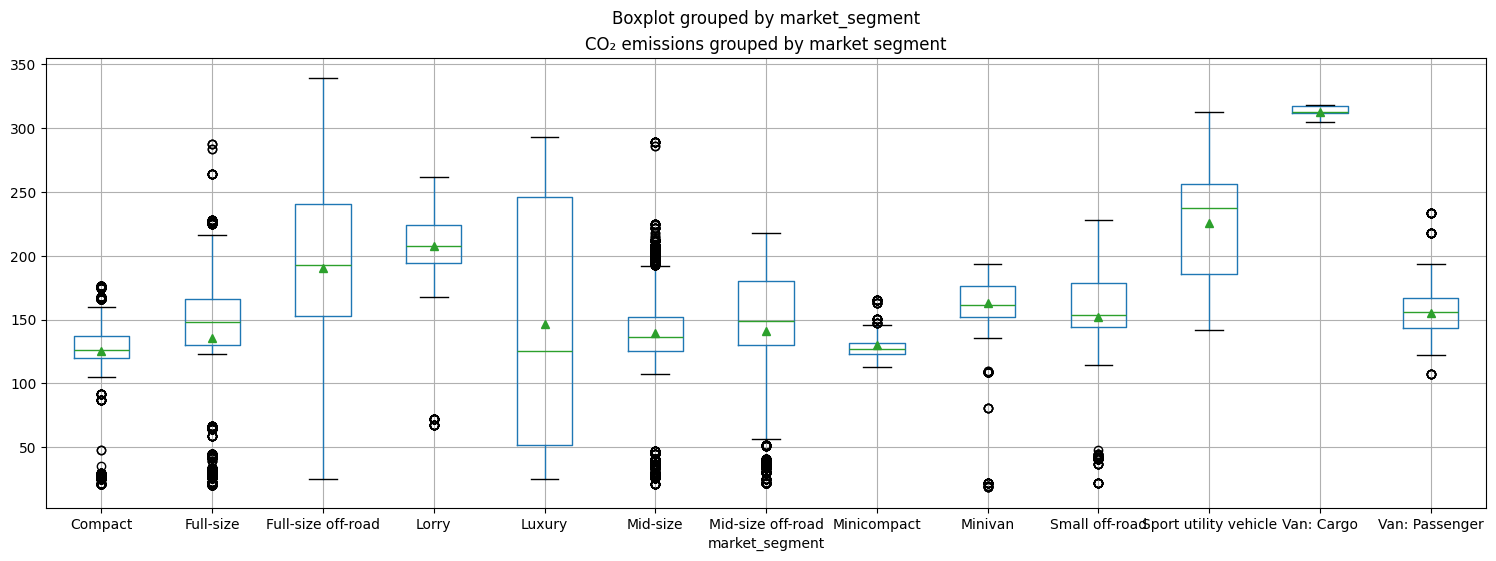

In [139]:
spain_emissions.boxplot(column="emissions_gCO2_km", by="market_segment", showmeans=True, figsize=(18, 6)).set_title("CO\u2082 emissions grouped by market segment");

Mentre nel grafico successivo vengono mostrati gli stessi valori, ma in relazione alla tipologia di motore. Quasi tutti boxplot hanno i valori di media e mediana che si assestano tra 150 e 200, presentando però anche in questo caso molti outlier.

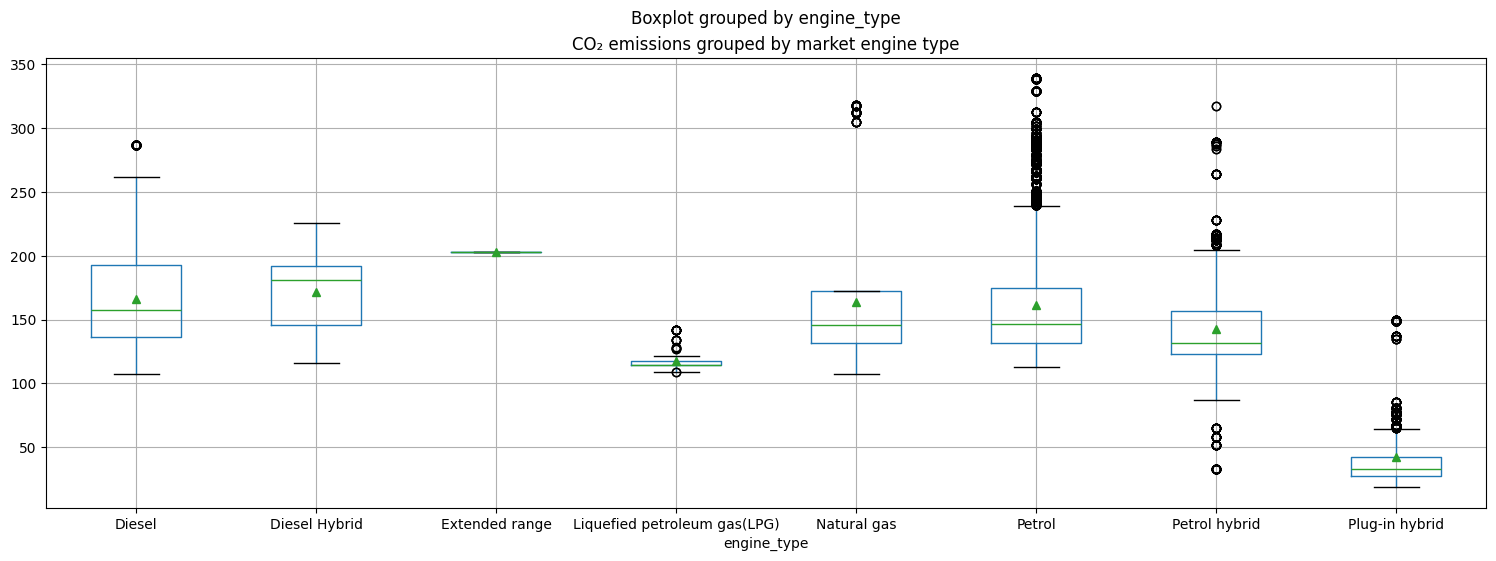

In [140]:
spain_emissions.boxplot(column="emissions_gCO2_km", by="engine_type", showmeans=True, figsize=(18, 6)).set_title("CO\u2082 emissions grouped by market engine type");

### Scelta delle colonne di `spain_emissions` per l'addestramento
Questa ultima parte dell'omogeneizzazione di `spain_emissions` seleziona solo le colonne utilizzate nell'addestramento rinominandole e facendo le ultime modifiche ai valori delle colonne, in modo da utilizzare uno standard comune agli altri dataset.

In [141]:
old_columns = ["Year", "make", "model", "engine_displacement_cm3", "consumption_l_100km", "engine_type", "emissions_gCO2_km", "transmission"]
new_columns = ["Year", "Manufacturer", "Model", "Engine_cm3", "Fuel_consumption", "Fuel_type", "CO2_Emissions", "Transmission_type"]
columns_dict = dict(zip(old_columns, new_columns))

In [142]:
spain_emissions = spain_emissions[old_columns].rename(columns = columns_dict)

Da questo punto in poi, Liquefied Petroleum Gas (LPG) verrà semplicemente sostituito con LPG.

In [143]:
spain_emissions["Fuel_type"] = spain_emissions["Fuel_type"].replace("Liquefied petroleum gas(LPG)", "LPG")

# **Omogeneizzazione di `canada_emissions`**

### Gestione tipi di carburante

All'interno del dataset proveniente dal ministero canadese sono presenti dati riguardanti il tipo di carburante (colonna "Fuel type").

La cella seguente mostra il numero di occorrenze di ogni lettera nella colonna Fuel type.

In [144]:
canada_emissions["Fuel type"].value_counts()

,count
Fuel type,
X,10445
Z,6314
E,770
D,199
N,38


Riportiamo sotto il significato delle lettere.

- `X`: Benzina normale (ha un indice di ottano più basso ed è quindi meno resistente alla detonazione)
- `Z`: Benzina premium (ha un indice di ottano più alto e offre una maggiore resistenza alla detonazione. È ideale per motori ad alte prestazioni, che hanno un rapporto di compressione                           più elevato e richiedono un carburante più stabile.)
- `D`: Diesel
- `E`: Etanolo(E85)
- `N`: gas naturale

Per motivi di compatibilità dei dataset è superfluo mantenere la distinzione tra benzina normale e benzina premium. Compattiamo quindi le due lettere X e Z in una parola unica: Petrol.
Inoltre trasformiamo anche E in Etanolo, N in Natural gas e D in Diesel per gli stessi motivi di confrontabilità.
Prima di iniziare a modificare il dataframe per poter effettuare tutte le doverose modifiche per renderlo confrontabile con gli altri dataset ne salviamo una copia per evitare di perdere quello originale che potrebbe tornare utile.

In [145]:
canada_emissions_copy = canada_emissions.copy()
canada_emissions["Fuel type"] = canada_emissions["Fuel type"].replace({'X': 'Petrol', 'Z': 'Petrol', 'D': 'Diesel', 'N': 'Natural Gas', 'E': 'Ethanol'})
canada_emissions["Fuel type"].value_counts()

,count
Fuel type,
Petrol,16759
Ethanol,770
Diesel,199
Natural Gas,38


Il seguente grafico a torta mostra la percentuale dei diversi tipi di carburante presi in considerazione. Si può notare che la maggior parte dei dati riguardano veicoli a benzina.

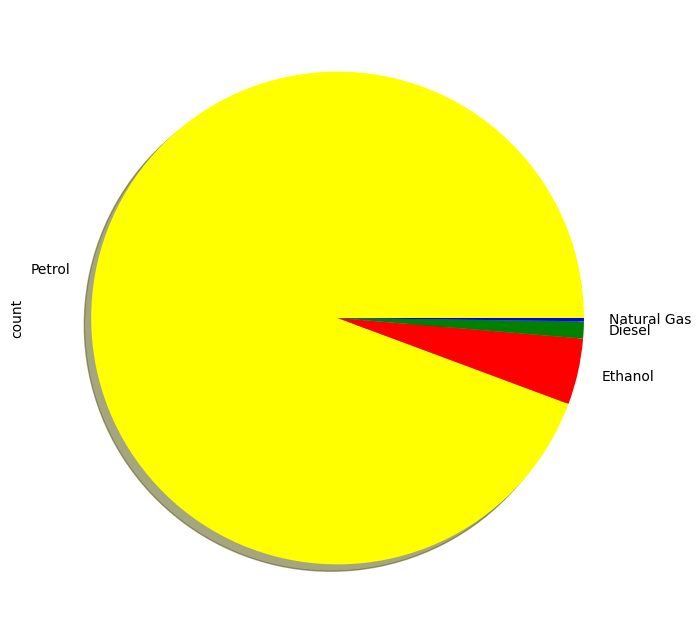

In [146]:
fuel_type_colors = {"Petrol": "yellow", "Ethanol": "red", "Diesel": "green", "Natural Gas": "blue"}
canada_fuel_type = canada_emissions["Fuel type"].value_counts()
canada_fuel_type.plot.pie(colors = canada_fuel_type.index.map(fuel_type_colors), shadow=True, figsize=(8,8))
plt.show()

### Eliminazione colonne superflue e rename delle feature importanti

E' inoltre doveroso eliminare le feature City, Highway, Combined che indicano rispettivamente il consumo di carburante: nelle strade di città, nelle autostrade e in entrambe. Eliminiamo inoltre la colonna superflua dell'id, quella del tipo veicolo (Vehicle class) e quella del numero di cilindri (Cylinders) del veicolo, non presente negli altri dataframe.

In [147]:
canada_emissions = canada_emissions.drop(["_id","Highway (L/100 km)","City (L/100 km)", "Combined (L/100 km)", "Vehicle class", "Cylinders"], axis=1)
canada_emissions.head(5)

,Model year,Make,Model,Engine_cm3,Transmission,Fuel type,Combined (mpg),CO2 emissions (g/km)
0,1995,Acura,Integra,1800.0,A4,Petrol,32,202
1,1995,Acura,Integra,1800.0,M5,Petrol,34,193
2,1995,Acura,Integra GS-R,1800.0,M5,Petrol,34,191
3,1995,Acura,Legend,3200.0,A4,Petrol,26,251
4,1995,Acura,Legend Coupe,3200.0,A4,Petrol,25,260


La celle seguente serve solo per modificare i nomi delle feature in modo che siano compatibili con gli altri dataset.

In [148]:
canada_emissions = canada_emissions.rename(columns={"Model year": "Year","Make": "Manufacturer","Fuel type": "Fuel_type", "Transmission": "Transmission_type","Combined (mpg)": "Fuel_consumption", "CO2 emissions (g/km)": "CO2_Emissions"})
canada_emissions.head(5)

,Year,Manufacturer,Model,Engine_cm3,Transmission_type,Fuel_type,Fuel_consumption,CO2_Emissions
0,1995,Acura,Integra,1800.0,A4,Petrol,32,202
1,1995,Acura,Integra,1800.0,M5,Petrol,34,193
2,1995,Acura,Integra GS-R,1800.0,M5,Petrol,34,191
3,1995,Acura,Legend,3200.0,A4,Petrol,26,251
4,1995,Acura,Legend Coupe,3200.0,A4,Petrol,25,260


### Gestione del tipo di trasmissione

Le prossime celle servono per rendere confrontabili con gli altri dataframe i valori riguardanti il tipo di trasmissione. In particolare trasformiamo tutti i valori di trasmissioni inizianti per A in Automatic e tutti quelli inizianti per M in Manual eccetto per i valori AM (che sarebbero automated manual) che verranno eliminati per evitare incomprensioni dato che gli altri dataset distinguono solamente tra cambio manuale e automatico.

In [149]:
index_to_drop = canada_emissions[canada_emissions["Transmission_type"].str.startswith("AM")].index
canada_emissions = canada_emissions.drop(index_to_drop)
canada_emissions["Transmission_type"] = canada_emissions["Transmission_type"].replace({r'^M.*': 'Manual',r'^A.*': 'Automatic' }, regex=True)
canada_emissions["Transmission_type"].value_counts()

,count
Transmission_type,
Automatic,12730
Manual,4848


Mostriamo ora i risultati appena ottenuti in un grafico a torta.

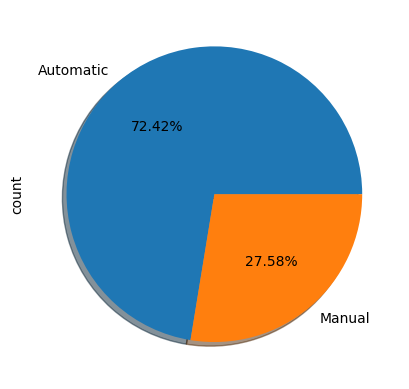

In [150]:
canada_emissions["Transmission_type"].value_counts().plot.pie(autopct="%.2f%%", shadow=True)
plt.show()

Come ci aspettavamo grazie allì'uso della funzione `value_counts()` i veicoli a cambio automatico sono la maggioranza.

### Dataset risultante

Adattamento finale del nome del modello eliminando la casa automobilistica e le informazioni aggiuntive.

In [151]:
# Per rimuovere il nome della casa automobilistica e le informazioni aggiuntive dal nome del modello
def remove_manufacturer(make_model):
    make = make_model["Manufacturer"]
    model = make_model["Model"]
    removedManufacturer = model.replace(make, "").split()
    model = [word for word in removedManufacturer if word not in useless_words][0]
    return model

In [152]:
canada_emissions["Model"] = canada_emissions[["Manufacturer", "Model"]].apply(remove_manufacturer, axis=1)

Mostriamo di seguito il dataframe risultante `canada_emissions`

In [153]:
canada_emissions.head(10)

,Year,Manufacturer,Model,Engine_cm3,Transmission_type,Fuel_type,Fuel_consumption,CO2_Emissions
0,1995,Acura,Integra,1800.0,Automatic,Petrol,32,202
1,1995,Acura,Integra,1800.0,Manual,Petrol,34,193
2,1995,Acura,Integra,1800.0,Manual,Petrol,34,191
3,1995,Acura,Legend,3200.0,Automatic,Petrol,26,251
4,1995,Acura,Legend,3200.0,Automatic,Petrol,25,260
5,1995,Acura,Legend,3200.0,Manual,Petrol,25,258
6,1995,Acura,NSX,3000.0,Automatic,Petrol,24,267
7,1995,Acura,NSX,3000.0,Manual,Petrol,25,255
8,1995,Alfa Romeo,164,3000.0,Automatic,Petrol,22,301
9,1995,Alfa Romeo,164,3000.0,Manual,Petrol,24,267


# Unione dei dataset

In [154]:
emissions = pd.concat([spain_emissions, canada_emissions, uk_emissions], ignore_index=True)

Infine, per i contenuti di tipo stringa come `Manufacturer` e `Model`, sarà necessaria una standardizzazione tra i diversi dataset. Lo standard scelto è la maiuscola per il primo carattere e la minuscola per gli altri caratteri.

In [155]:
capitalize_columns = ["Manufacturer", "Model"]
emissions[capitalize_columns] = emissions[capitalize_columns].apply(lambda col: col.str.capitalize())

Nella prossima cella, mostriamo una breve descrizione in formato tabellare delle feature numeriche del dataset completo

In [156]:
emissions.describe()

,Year,Engine_cm3,Fuel_consumption,CO2_Emissions
count,93653.000000,93653.000000,93653.000000,93653.000000
mean,2007.176844,2305.041814,10.977253,189.443734
std,4.323387,1102.192432,8.675710,64.708809
min,1995.000000,110.000000,0.450000,18.666667
25%,2004.000000,1598.000000,5.900000,144.000000
50%,2008.000000,1993.000000,7.483333,179.000000
75%,2011.000000,2685.000000,10.800000,224.000000
max,2014.000000,19894.000000,78.000000,590.000000


In [157]:
emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93653 entries, 0 to 93652
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               93653 non-null  float64
 1   Manufacturer       93653 non-null  object 
 2   Model              93653 non-null  object 
 3   Engine_cm3         93653 non-null  float64
 4   Fuel_consumption   93653 non-null  float64
 5   Fuel_type          93653 non-null  object 
 6   CO2_Emissions      93653 non-null  float64
 7   Transmission_type  93653 non-null  object 
dtypes: float64(4), object(4)
memory usage: 5.7+ MB


# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei tre dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `Year`: anno in cui è stato prodotto il veicolo
- `Manufacturer`: casa automobilistica che ha prodotto il veicolo
- `Model`: nome del modello del veicolo
- `Engine_cm3`: volume del motore in cm<sup>3</sup>
- `Transmission_type`: tipologia di trasmissione del veicolo, ovvero se il cambio della marcia è automatico o manuale
- `Fuel_type`: tipologia di carburante usato nel veicolo. Per esempio può essere benzina, diesel, benzina e ibrida ecc.
- `Fuel_consumption`: i litri di carburante consumati dal veicolo ogni 100 km

La variabile dipendente target dell'addestramento è `CO2_Emissions`, la quantità di CO<sub>2</sub> emessa dal veicolo in grammi per km.

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Data Preparation ----------
X = emissions.drop("CO2_Emissions", axis=1)
y = emissions["CO2_Emissions"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Limit the number of samples
X_train = X_train.sample(n=22500, random_state=42)
y_train = y_train.loc[X_train.index]
X_test = X_test.sample(n=2500, random_state=42)
y_test = y_test.loc[X_test.index]

categorical_features = ['Manufacturer', 'Model', 'Fuel_type', 'Transmission_type']
numerical_features = ['Year', 'Engine_cm3', 'Fuel_consumption']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[categorical_features])

def encode_df(df):
    enc = encoder.transform(df[categorical_features])
    enc_df = pd.DataFrame(
        enc, columns=encoder.get_feature_names_out(categorical_features), index=df.index
    )
    return pd.concat([df[numerical_features].reset_index(drop=True),
                      enc_df.reset_index(drop=True)], axis=1)

X_train_enc = encode_df(X_train)
X_test_enc = encode_df(X_test)

def to_tensor(x_df, y_series):
    X_t = torch.tensor(x_df.values, dtype=torch.float32)
    y_t = torch.tensor(y_series.values, dtype=torch.float32).unsqueeze(1)
    return X_t, y_t

X_train_tensor, y_train_tensor = to_tensor(X_train_enc, y_train)
X_test_tensor, y_test_tensor = to_tensor(X_test_enc, y_test)

# Full training dataset
full_dataset = TensorDataset(X_train_tensor, y_train_tensor)

## Definizione dei Modelli: MLP e KAN

In questo blocco vengono definite due architetture di modelli per regressione:

* **`MLP` (Multi-Layer Perceptron)**: una rete neurale feed-forward costruita in modo flessibile a partire da:

  * `input_dim`: numero di feature in input;
  * `hidden_sizes`: lista con il numero di neuroni per ciascun layer nascosto;
  * `dropout`: tasso di dropout per regolarizzare l'addestramento.
    Ogni layer nascosto è seguito da un'attivazione `ReLU` e un livello di `Dropout`. L'output è uno scalare, indicato per problemi di regressione.

* **`build_kan`**: funzione che restituisce un modello **KAN (Kolmogorov–Arnold Networks)**, una rete neurale basata su un'architettura alternativa ai classici MLP, caratterizzata da:

  * una struttura definita tramite la lista `width`,
  * griglie di punti (`grid`) e grado del polinomio (`k`) per le interpolazioni,
  * seme casuale (`seed`) per la riproducibilità e
  * assegnazione del modello al corretto `device` (CPU o GPU).


In [159]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

def build_kan(input_dim, width, grid, k, seed=0):
    model = KAN(
        width=[input_dim] + list(width) + [1],
        grid=grid,
        k=k,
        seed=seed,
        device=device
    )
    model.speed()  # enable efficient mode: disable symbolic branch
    return model

def build_random_forest(**params):
    return RandomForestRegressor(**params)

def build_xgboost(**params):
    return xgb.XGBRegressor(**params)

## Nested Random Search con Early Stopping

Questo blocco di codice implementa una procedura completa di **Nested Random Search** per la selezione di iperparametri di modelli di regressione in PyTorch, integrando una strategia di **Early Stopping** per migliorare l'efficienza del training.

* La classe `EarlyStopper` consente di interrompere l'addestramento anticipatamente se la loss di validazione non migliora per un numero di epoche definito (`patience`), riducendo il rischio di overfitting e velocizzando l'ottimizzazione.
* Le funzioni `train_epoch` ed `eval_loss` gestiscono rispettivamente il training e la valutazione della loss media su un dataset.
* La funzione principale `nested_random_search` esegue una **Nested Cross-Validation**, dove:

  * Il ciclo esterno (outer loop) valuta le prestazioni generali del modello su diversi split train/test.
  * Il ciclo interno (inner loop) esplora combinazioni casuali di iperparametri tramite `ParameterSampler` per ottimizzare la loss di validazione, utilizzando K-Fold CV.
* Per ogni fold esterno, viene selezionata la migliore combinazione di iperparametri trovata all’interno, con successivo riaddestramento sul training set esteso e valutazione finale sul test set.

Il risultato è una lista di tuple contenenti i migliori parametri di modello, parametri di training e loss finale per ciascun fold esterno, utile per valutare la **robustezza e generalizzazione** del modello selezionato.

In [160]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

def train_epoch(model, loader, optimizer, criterion, l2_lambda=0.0):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)

        if l2_lambda > 0:
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def nested_random_search_neural(model_builder, param_dist, dataset,
                               outer_folds=5, inner_folds=3, n_iter=10,
                               early_patience=10, early_min_delta=1e-4):
    """
    Esegue Nested Random Search con Randomized Search interno per reti neurali (MLP e KAN)
    Args:
        model_builder: funzione che crea un modello dato model_params
        param_dist: dizionario di liste per ogni iperparametro (model_params + training_params)
        dataset: TensorDataset per il training
        outer_folds, inner_folds: numeri di fold per CV
        n_iter: numero di campioni di Random Search
        early_patience: numero di epoche di pazienza per Early Stopping
        early_min_delta: miglioramento minimo per considerare un progresso
    Returns:
        lista di tuple (best_model_params, best_training_params, test_loss) per ogni outer fold
    """
    # Chiavi riservate per training
    train_keys = ['lr', 'batch_size', 'l2_lambda']
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=42)
    results = []

    for train_idx, test_idx in outer_cv.split(range(len(dataset))):
        inner_train = Subset(dataset, train_idx)
        inner_test = Subset(dataset, test_idx)
        best_val_loss = float('inf')
        best_model_params, best_train_params = None, None

        # Random Search interno
        for params in ParameterSampler(param_dist, n_iter=n_iter, random_state=42):
            # Separa i parametri del modello da quelli di training
            model_params = {k: v for k, v in params.items() if k not in train_keys}
            train_params = {k: v for k, v in params.items() if k in train_keys}

            # Valutazione su inner_folds con Early Stopping
            inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=42)
            val_losses = []
            for subtrain_idx, val_idx in inner_cv.split(range(len(inner_train))):
                subtrain = Subset(inner_train, subtrain_idx)
                valset = Subset(inner_train, val_idx)
                train_loader = DataLoader(subtrain, batch_size=train_params['batch_size'], shuffle=True)
                val_loader = DataLoader(valset, batch_size=train_params['batch_size'], shuffle=False)

                # Costruisci modello
                model = model_builder(**model_params)
                if hasattr(model, 'speed'):
                    model.speed()
                model.to(device)
                optimizer = optim.Adam(model.parameters(), lr=train_params['lr'], weight_decay=train_params.get('l2_lambda', 0.0))
                stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

                # Training
                for epoch in range(1000):
                    train_epoch(model, train_loader, optimizer, nn.MSELoss(), l2_lambda=train_params.get('l2_lambda', 0.0))
                    val_loss = eval_loss(model, val_loader, nn.MSELoss())
                    if stopper.early_stop(val_loss):
                        break

                # Loss di validazione
                val_losses.append(eval_loss(model, val_loader, nn.MSELoss()))

            mean_val = np.mean(val_losses)
            if mean_val < best_val_loss:
                best_val_loss = mean_val
                best_model_params = model_params
                best_train_params = train_params

        # Riaddestramento con i migliori parametri su tutto il sottoinsieme interno con Early Stopping
        full_train_loader = DataLoader(inner_train, batch_size=best_train_params['batch_size'], shuffle=True)
        test_loader = DataLoader(inner_test, batch_size=best_train_params['batch_size'], shuffle=False)

        final_model = model_builder(**best_model_params)
        if hasattr(final_model, 'speed'):
            final_model.speed()
        final_model.to(device)

        optimizer = optim.Adam(final_model.parameters(), lr=best_train_params['lr'], weight_decay=train_params.get('l2_lambda', 0.0))
        stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

        for epoch in range(1000):
            train_epoch(final_model, full_train_loader, optimizer, nn.MSELoss(), l2_lambda=best_train_params.get('l2_lambda', 0.0))
            if stopper.early_stop(eval_loss(final_model, full_train_loader, nn.MSELoss())):
                break

        test_loss = eval_loss(final_model, test_loader, nn.MSELoss())
        results.append((best_model_params, best_train_params, test_loss))

    return results

def nested_random_search_sklearn(model_builder, param_dist, X_data, y_data,
                                outer_folds=5, inner_folds=3, n_iter=10):
    """
    Nested Random Search per modelli sklearn e XGBoost
    """
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=42)
    results = []

    for train_idx, test_idx in outer_cv.split(X_data):
        X_inner_train, X_inner_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_inner_train, y_inner_test = y_data.iloc[train_idx], y_data.iloc[test_idx]

        best_val_mse = float('inf')
        best_params = None

        for params in ParameterSampler(param_dist, n_iter=n_iter, random_state=42):
            inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=42)
            val_mses = []

            for subtrain_idx, val_idx in inner_cv.split(X_inner_train):
                X_subtrain, X_val = X_inner_train.iloc[subtrain_idx], X_inner_train.iloc[val_idx]
                y_subtrain, y_val = y_inner_train.iloc[subtrain_idx], y_inner_train.iloc[val_idx]

                model = model_builder(**params)
                model.fit(X_subtrain, y_subtrain)
                val_pred = model.predict(X_val)
                val_mse = mean_squared_error(y_val, val_pred)
                val_mses.append(val_mse)

            mean_val_mse = np.mean(val_mses)
            if mean_val_mse < best_val_mse:
                best_val_mse = mean_val_mse
                best_params = params

        # Riaddestramento con los mejores parámetros
        final_model = model_builder(**best_params)
        final_model.fit(X_inner_train, y_inner_train)
        test_pred = final_model.predict(X_inner_test)
        test_mse = mean_squared_error(y_inner_test, test_pred)

        results.append((best_params, {}, test_mse))

    return results

## Esecuzione del Nested Random Search su MLP e KAN

In questa sezione viene eseguita la **ricerca di iperparametri tramite Nested Random Search** per due diverse architetture di modelli:
**MLP (Multi-Layer Perceptron)** e **KAN (Kolmogorov–Arnold Networks)**.

### Definizione degli spazi degli iperparametri:

* `mlp_param_dist`: contiene combinazioni di dimensioni dei layer nascosti, tassi di dropout, learning rate, batch size e numero massimo di epoche per il training del modello MLP.
* `kan_param_dist`: definisce i parametri strutturali del modello KAN come larghezza dei layer (`width`), numero di punti griglia (`grid`), grado delle funzioni di base (`k`), e parametri di training.

### Esecuzione:

* Viene eseguita la funzione `nested_random_search` separatamente per ciascun modello.
* I risultati di ogni fold (configurazioni migliori e relativa test loss) vengono stampati a video per permettere un confronto diretto tra le due architetture.

Questo confronto sistematico consente di determinare **quale modello e configurazione di iperparametri offra le migliori prestazioni** su un problema di regressione, valutato con Cross-Validation stratificata e early stopping.


---

**Scelta del numero di iterazioni per RandomizedSearchCV con MLP grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 72
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 72.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{72}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{62}{72}\right)} = \frac{-2.3026}{\ln(\frac{62}{72})} \approx \frac{2.3026}{0.1495} \approx 15.40
$$

Quindi, con **15 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 72 combinazioni.

---

**Scelta del numero di iterazioni per RandomizedSearchCV con KAN grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 32
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 32.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{32}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{22}{32}\right)} = \frac{-2.3026}{\ln(\frac{22}{32})} \approx \frac{2.3026}{0.3707} \approx 6.21
$$

Quindi, con **6 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 32 combinazioni.

---

**Scelta del numero di iterazioni per RandomizedSearchCV con RandomForest grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 144
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 144.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{144}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{134}{144}\right)} = \frac{-2.3026}{\ln(\frac{134}{144})} \approx \frac{2.3026}{0.0722} \approx 31.89
$$

Quindi, con **32 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 144 combinazioni.

---

**Scelta del numero di iterazioni per RandomizedSearchCV con XGBoost grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 2916
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 2916.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{2916}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{2906}{2916}\right)} = \frac{-2.3026}{\ln(\frac{2906}{2916})} \approx \frac{2.3026}{0.0034} \approx 677.23
$$

Quindi, con **677 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 2916 combinazioni.

---

**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [161]:
input_dim = X_train_tensor.shape[1]
mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(32,32), (64,64), (128,)],
    'dropout': [0.1, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'batch_size': [32],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}

kan_param_dist = {
    'input_dim': [input_dim],
    'width': [(8,4), (16,8)],
    'grid': [5, 10],
    'k': [2, 4],
    'seed': [0],
    'lr': [1e-3],
    'batch_size': [32],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}

rf_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.5, 1.0, 2.0],
    'reg_lambda': [2.0, 5.0, 10.0],
    'random_state': [42]
}

# ---------- Run Nested Random Search ----------
print("=== Nested Random Search Results ===\n")

print("MLP Results:")
mlp_results = nested_random_search_neural(
    lambda **p: MLP(**{k: v for k, v in p.items() if k in ['input_dim', 'hidden_sizes', 'dropout']}), 
    mlp_param_dist, 
    full_dataset,
    n_iter=15)
for i, (model_p, train_p, loss) in enumerate(mlp_results):
    print(f"Fold {i+1} - Model: {model_p}, Train: {train_p}, Test Loss: {loss:.4f}")

print("\nKAN Results:")
kan_results = nested_random_search_neural(
    lambda **p: build_kan(**{k: v for k, v in p.items() if k in ['input_dim', 'width', 'grid', 'k', 'seed']}), 
    kan_param_dist, 
    full_dataset,
    n_iter=6)
for i, (model_p, train_p, loss) in enumerate(kan_results):
    print(f"Fold {i+1} - Model: {model_p}, Train: {train_p}, Test Loss: {loss:.4f}")

print("\nRandom Forest Results:")
rf_results = nested_random_search_sklearn(build_random_forest, rf_param_dist, X_train_enc, y_train, n_iter=32)
for i, (model_p, _, loss) in enumerate(rf_results):
    print(f"Fold {i+1} - Params: {model_p}, Test MSE: {loss:.4f}")

print("\nXGBoost Results:")
xgb_results = nested_random_search_sklearn(build_xgboost, xgb_param_dist, X_train_enc, y_train, n_iter=677)
for i, (model_p, _, loss) in enumerate(xgb_results):
    print(f"Fold {i+1} - Params: {model_p}, Test MSE: {loss:.4f}")

=== Nested Random Search Results ===

MLP Results:
Fold 1 - Model: {'input_dim': 150, 'hidden_sizes': (128,), 'dropout': 0.1}, Train: {'lr': 0.001, 'l2_lambda': 1e-05, 'batch_size': 32}, Test Loss: 1665.9027
Fold 2 - Model: {'input_dim': 150, 'hidden_sizes': (128,), 'dropout': 0.1}, Train: {'lr': 0.001, 'l2_lambda': 1e-05, 'batch_size': 32}, Test Loss: 2202.1177
Fold 3 - Model: {'input_dim': 150, 'hidden_sizes': (32, 32), 'dropout': 0.1}, Train: {'lr': 0.001, 'l2_lambda': 0.0001, 'batch_size': 32}, Test Loss: 682.7062
Fold 4 - Model: {'input_dim': 150, 'hidden_sizes': (32, 32), 'dropout': 0.1}, Train: {'lr': 0.001, 'l2_lambda': 0.0001, 'batch_size': 32}, Test Loss: 1525.1918
Fold 5 - Model: {'input_dim': 150, 'hidden_sizes': (32, 32), 'dropout': 0.1}, Train: {'lr': 0.001, 'l2_lambda': 0.0001, 'batch_size': 32}, Test Loss: 1652.1353

KAN Results:
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint direc

## Valutazione Finale dei Migliori Modelli: MLP vs KAN

Questa sezione si occupa di confrontare i **migliori modelli trovati** durante la ricerca annidata (`nested_random_search`) per le due architetture:

* Viene definita la funzione `evaluate_model`, che calcola l'**MSE (Mean Squared Error)** di un modello su un `DataLoader`.
* Si identificano i **migliori modelli MLP e KAN**, selezionando quelli con la più bassa *test loss* tra i risultati di cross-validation.
* I modelli vengono **riaddestrati** usando gli stessi dati di test (dell'ultimo fold esterno) per analizzare:

  * **Train loss** ad ogni epoca;
  * **Validation loss** ad ogni epoca.

Questa fase è utile per:

* Verificare se il modello si **adatta bene** al test set senza overfitting;
* Raccogliere dati da **visualizzare graficamente** (es. curva di apprendimento) per analizzare il comportamento delle due architetture nel tempo.


In [165]:
def evaluate_model_neural(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in data_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            loss = criterion(model(Xb), yb)
            total_loss += loss.item() * Xb.size(0)
    return total_loss / len(data_loader.dataset)

def count_params(model):
    if isinstance(model, MLP):
        try:
            return sum(p.numel() for p in model.parameters() if p.requires_grad)
        except Exception:
            return 0

    elif isinstance(model, KAN):
        try:
            if not model.width or len(model.width) < 2:
                return 0

            sum_ab_terms = 0
            for i in range(len(model.width) - 1):
                a = model.width[i]
                b = model.width[i+1]

                if isinstance(a, list):
                    a = a[0]
                if isinstance(b, list):
                    b = b[0]

                sum_ab_terms += (a * b)

            return sum_ab_terms * (model.grid + model.k)
        except Exception as e:
            print(f"Error calculating KAN parameters: {e}")
            return 0

    elif isinstance(model, RandomForestRegressor):
        total_nodes = 0
        if hasattr(model, 'estimators_'):
            for tree in model.estimators_:
                if hasattr(tree, 'tree_'):
                    total_nodes += tree.tree_.node_count
            return total_nodes
        else:
            return 0

    elif isinstance(model, xgb.XGBRegressor):
        total_nodes = 0

        try:
            booster = model.get_booster()
            tree_dumps = booster.get_dump(dump_format='json')

            def count_nodes_in_json_tree(node):
                count = 1
                if 'children' in node:
                    for child in node['children']:
                        count += count_nodes_in_json_tree(child)
                return count

            for tree_dump_str in tree_dumps:
                tree_json = json.loads(tree_dump_str)
                total_nodes += count_nodes_in_json_tree(tree_json)

            return total_nodes
        except Exception as e:
            print(f"Error calculating exact XGBoost complexity: {e}")
            return 0
    else:
        return 0

def get_predictions_neural(model, data_loader):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for Xb, yb in data_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds.append(model(Xb).cpu().numpy())
            true.append(yb.cpu().numpy())
    return np.vstack(true), np.vstack(preds)

def compute_confidence_interval(data, confidence=0.95):
    n = len(data)
    if n <= 1:
        return np.mean(data) if n > 0 else np.nan, np.nan, np.nan
    mean, se = np.mean(data), stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, mean - h, mean + h


def compute_metrics_neural(model, data_loader):
    y_true, y_pred = get_predictions_neural(model, data_loader)
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    mse_scores = (y_true_flat - y_pred_flat)**2
    mae_scores = np.abs(y_true_flat - y_pred_flat)
    mape_scores = np.abs((y_true_flat - y_pred_flat) / y_true_flat) * 100
    mape_scores = mape_scores[np.isfinite(mape_scores) & (y_true_flat != 0)]

    mse, mse_ci_lower, mse_ci_upper = compute_confidence_interval(mse_scores)
    r2 = r2_score(y_true_flat, y_pred_flat)
    mae, mae_ci_lower, mae_ci_upper = compute_confidence_interval(mae_scores)
    mape, mape_ci_lower, mape_ci_upper = compute_confidence_interval(mape_scores)
    max_err = max_error(y_true_flat, y_pred_flat)
    n = len(y_true_flat)
    k = data_loader.dataset[0][0].shape[0]
    p = count_params(model)
    try:
        r2 = r2_score(y_true_flat, y_pred_flat)
        if n - k - 1 > 0:
            r2_adj = 1 - (1 - r2) * (n - 1) / (n - k - 1)
        else:
             r2_adj = r2
    except ZeroDivisionError:
        r2_adj = r2
    return (mse, mse_ci_lower, mse_ci_upper), r2, r2_adj, (mae, mae_ci_lower, mae_ci_upper), (mape, mape_ci_lower, mape_ci_upper), max_err, p

def compute_metrics_sklearn(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test_np = y_test.values.flatten()
    y_pred_np = y_pred.flatten()

    min_len = min(len(y_test_np), len(y_pred_np))
    y_test_np = y_test_np[:min_len]
    y_pred_np = y_pred_np[:min_len]


    mse_scores = (y_test_np - y_pred_np)**2
    mae_scores = np.abs(y_test_np - y_pred_np)
    mape_scores = np.abs((y_test_np - y_pred_np) / y_test_np) * 100
    mape_scores = mape_scores[np.isfinite(mape_scores) & (y_test_np != 0)]


    mse, mse_ci_lower, mse_ci_upper = compute_confidence_interval(mse_scores)
    r2 = r2_score(y_test_np, y_pred_np)
    mae, mae_ci_lower, mae_ci_upper = compute_confidence_interval(mae_scores)
    mape, mape_ci_lower, mape_ci_upper = compute_confidence_interval(mape_scores)
    max_err = max_error(y_test_np, y_pred_np)
    n = len(y_test_np)
    k = X_test.shape[1]
    try:
         if n - k - 1 > 0:
            r2_adj = 1 - (1 - r2) * (n - 1) / (n - k - 1)
         else:
             r2_adj = r2
    except (ZeroDivisionError, ValueError):
        r2_adj = r2
    p = count_params(model)
    return (mse, mse_ci_lower, mse_ci_upper), r2, r2_adj, (mae, mae_ci_lower, mae_ci_upper), (mape, mape_ci_lower, mape_ci_upper), max_err, p

## Valutazione Finale e Confronto tra MLP e KAN

In questa sezione, vengono confrontati i modelli MLP (Multi-Layer Perceptron) e KAN (Kolmogorov–Arnold Networks) utilizzando metriche di regressione e visualizzazioni grafiche per analizzare le loro prestazioni.

### Metriche di Valutazione

Vengono calcolate le seguenti metriche sul test set:

* **MSE (Mean Squared Error)**: misura l'errore quadratico medio tra le predizioni del modello e i valori reali. Un valore più basso indica una migliore accuratezza del modello.

* **R² (Coefficiente di Determinazione)**: indica la proporzione della varianza nei dati dipendenti che è prevedibile dalle variabili indipendenti. Un valore più alto (fino a 1) suggerisce una migliore capacità predittiva.

* **R² Aggiustato**: modifica il R² standard penalizzando l'aggiunta di variabili indipendenti non significative, fornendo una misura più accurata della bontà del modello, specialmente quando si confrontano modelli con un numero diverso di predittori.&#x20;

* **Numero di Parametri Addestrabili**: indica la complessità del modello; modelli con un numero inferiore di parametri sono generalmente preferibili se le prestazioni sono comparabili, poiché tendono a generalizzare meglio e sono meno suscettibili all'overfitting.

### Visualizzazioni

1. **Curve di Loss per Epoca**: grafici che mostrano l'andamento della loss di training e di validazione per ciascun modello nel corso delle epoche, utili per identificare fenomeni di overfitting o underfitting.

2. **Confronto tramite Grafici a Barre**:

   * **Numero di Parametri**: confronta la complessità dei modelli.
   * **R² Aggiustato**: valuta la capacità predittiva tenendo conto della complessità del modello.
   * **MSE di Test**: misura l'accuratezza delle predizioni sui dati di test.([Cross Validated][1])

Queste analisi forniscono una panoramica completa delle prestazioni e della complessità dei modelli MLP e KAN, facilitando la selezione del modello più adatto per il problema in esame.


checkpoint directory created: ./model
saving model version 0.0
MLP Early stopping at epoch 60
KAN Early stopping at epoch 48


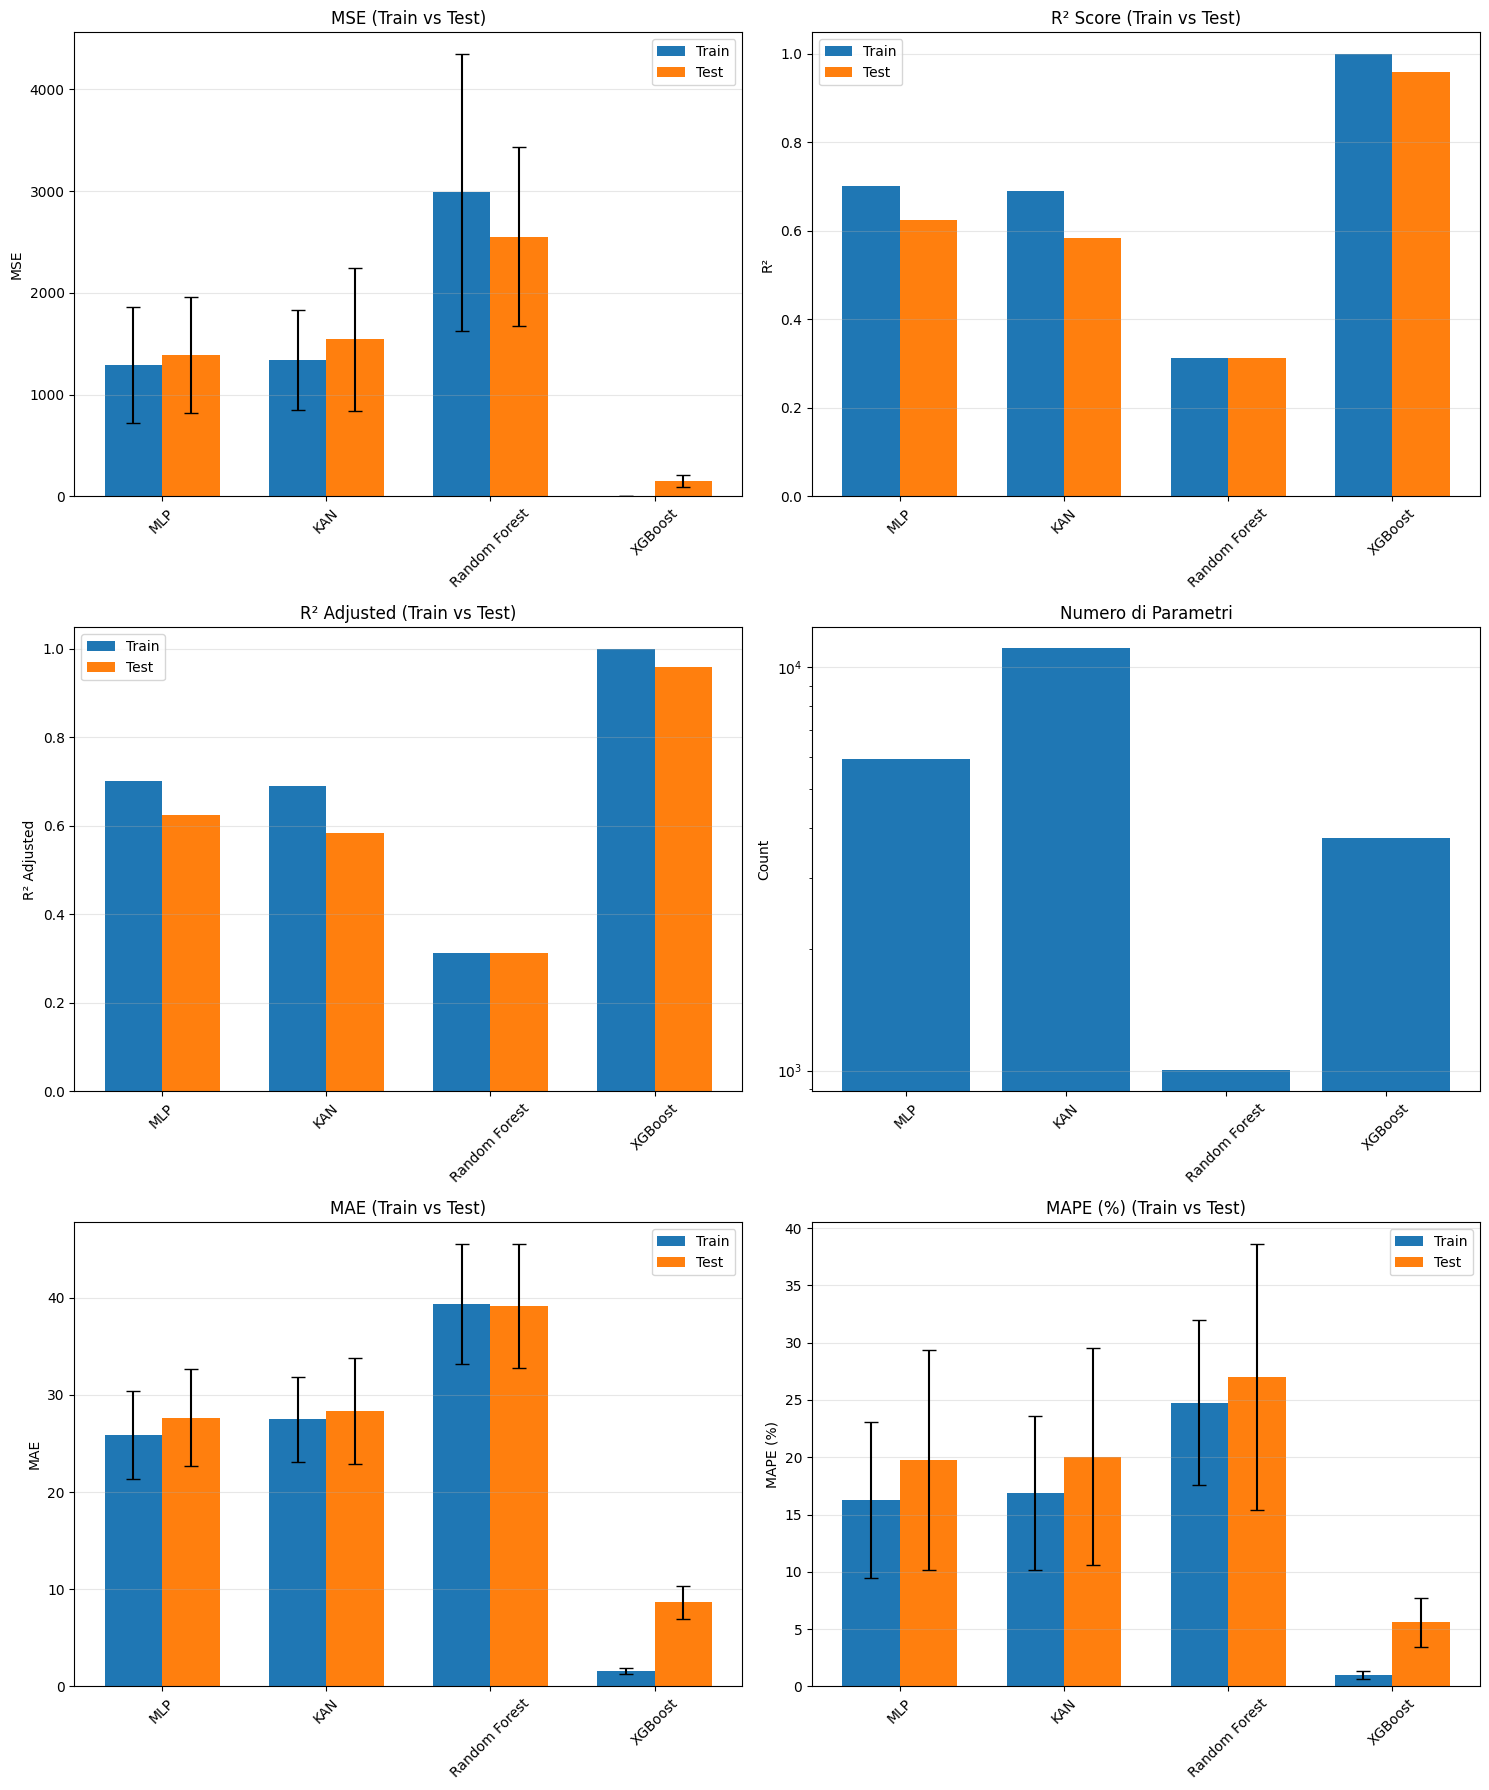


=== TABELLA RIASSUNTIVA ===
           Model  MSE_Train  MSE_Train_CI_Lower  MSE_Train_CI_Upper  \
0            MLP  1289.7255            717.3232           1862.1277   
1            KAN  1339.9244            850.4828           1829.3661   
2  Random Forest  2986.5803           1629.9284           4343.2321   
3        XGBoost     5.6759              2.6914              8.6605   

    MSE_Test  MSE_Test_CI_Lower  MSE_Test_CI_Upper  R²_Train  R²_Test  \
0  1389.5328           819.4652          1959.6005    0.7015   0.6256   
1  1544.3182           840.1451          2248.4913    0.6899   0.5839   
2  2553.0651          1672.4722          3433.6580    0.3137   0.3121   
3   148.4356            87.7325           209.1388    0.9987   0.9600   

   R²_Adjusted_Train  ...  MAE_Test_CI_Upper  MAPE_Train  MAPE_Train_CI_Lower  \
0             0.7015  ...            32.6254     16.2485               9.4226   
1             0.6899  ...            33.7664     16.8738              10.1808   
2     

In [166]:
# Selezione dei migliori modelli
best_mlp_idx = min(range(len(mlp_results)), key=lambda i: mlp_results[i][2])
best_mlp_params, best_mlp_train, _ = mlp_results[best_mlp_idx]

best_kan_idx = min(range(len(kan_results)), key=lambda i: kan_results[i][2])
best_kan_params, best_kan_train, _ = kan_results[best_kan_idx]

best_rf_idx = min(range(len(rf_results)), key=lambda i: rf_results[i][2])
best_rf_params, _, _ = rf_results[best_rf_idx]

best_xgb_idx = min(range(len(xgb_results)), key=lambda i: xgb_results[i][2])
best_xgb_params, _, _ = xgb_results[best_xgb_idx]


# Creazione dei modelli finali
mlp_model = MLP(**best_mlp_params).to(device)
kan_model = build_kan(**best_kan_params).to(device)
rf_model = build_random_forest(**best_rf_params)
xgb_model = build_xgboost(**best_xgb_params)

# Addestramento dei modelli sklearn
rf_model.fit(X_train_enc, y_train)
xgb_model.fit(X_train_enc, y_train)


# Preparazione dei loaders per i modelli neurali
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
train_idx, _ = list(outer_cv.split(range(len(full_dataset))))[-1]
train_loader = DataLoader(
    Subset(full_dataset, train_idx),
    batch_size=32,
    shuffle=True
)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)


# Addestramento dei modelli neurali
criterion = nn.MSELoss()
stopper_mlp = EarlyStopper(patience=10, min_delta=1e-4)
stopper_kan = EarlyStopper(patience=10, min_delta=1e-4)

# Training MLP
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=best_mlp_train['lr'])
for epoch in range(1000):
    train_loss_mlp = train_epoch(mlp_model, train_loader, optimizer_mlp, criterion, l2_lambda=best_mlp_train.get('l2_lambda', 0.0))
    val_loss_mlp = eval_loss(mlp_model, test_loader, criterion)
    if stopper_mlp.early_stop(val_loss_mlp):
        print(f"MLP Early stopping at epoch {epoch}")
        break

# Training KAN
optimizer_kan = optim.Adam(kan_model.parameters(), lr=best_kan_train['lr'])
for epoch in range(1000):
    train_loss_kan = train_epoch(kan_model, train_loader, optimizer_kan, criterion, l2_lambda=best_kan_train.get('l2_lambda', 0.0))
    val_loss_kan = eval_loss(kan_model, test_loader, criterion)
    if stopper_kan.early_stop(val_loss_kan):
        print(f"KAN Early stopping at epoch {epoch}")
        break


# Calcolo delle metriche
(mse_mlp_test, mse_mlp_test_ci_lower, mse_mlp_test_ci_upper), r2_mlp_test, r2_adj_mlp_test, (mae_mlp_test, mae_mlp_test_ci_lower, mae_mlp_test_ci_upper), (mape_mlp_test, mape_mlp_test_ci_lower, mape_mlp_test_ci_upper), max_err_mlp_test, params_mlp = compute_metrics_neural(mlp_model, test_loader)
(mse_kan_test, mse_kan_test_ci_lower, mse_kan_test_ci_upper), r2_kan_test, r2_adj_kan_test, (mae_kan_test, mae_kan_test_ci_lower, mae_kan_test_ci_upper), (mape_kan_test, mape_kan_test_ci_lower, mape_kan_test_ci_upper), max_err_kan_test, params_kan = compute_metrics_neural(kan_model, test_loader)
(mse_rf_test, mse_rf_test_ci_lower, mse_rf_test_ci_upper), r2_rf_test, r2_adj_rf_test, (mae_rf_test, mae_rf_test_ci_lower, mae_rf_test_ci_upper), (mape_rf_test, mape_rf_test_ci_lower, mape_rf_test_ci_upper), max_err_rf_test, params_rf = compute_metrics_sklearn(rf_model, X_test_enc, y_test)
(mse_xgb_test, mse_xgb_test_ci_lower, mse_xgb_test_ci_upper), r2_xgb_test, r2_adj_xgb_test, (mae_xgb_test, mae_xgb_test_ci_lower, mae_xgb_test_ci_upper), (mape_xgb_test, mape_xgb_test_ci_lower, mape_xgb_test_ci_upper), max_err_xgb_test, params_xgb = compute_metrics_sklearn(xgb_model, X_test_enc, y_test)

(mse_mlp_train, mse_mlp_train_ci_lower, mse_mlp_train_ci_upper), r2_mlp_train, r2_adj_mlp_train, (mae_mlp_train, mae_mlp_train_ci_lower, mae_mlp_train_ci_upper), (mape_mlp_train, mape_mlp_train_ci_lower, mape_mlp_train_ci_upper), max_err_mlp_train, _ = compute_metrics_neural(mlp_model, train_loader)
(mse_kan_train, mse_kan_train_ci_lower, mse_kan_train_ci_upper), r2_kan_train, r2_adj_kan_train, (mae_kan_train, mae_kan_train_ci_lower, mae_kan_train_ci_upper), (mape_kan_train, mape_kan_train_ci_lower, mape_kan_train_ci_upper), max_err_kan_train, _ = compute_metrics_neural(kan_model, train_loader)
(mse_rf_train, mse_rf_train_ci_lower, mse_rf_train_ci_upper), r2_rf_train, r2_adj_rf_train, (mae_rf_train, mae_rf_train_ci_lower, mae_rf_train_ci_upper), (mape_rf_train, mape_rf_train_ci_lower, mape_rf_train_ci_upper), max_err_rf_train, _ = compute_metrics_sklearn(rf_model, X_train_enc, y_train)
(mse_xgb_train, mse_xgb_train_ci_lower, mse_xgb_train_ci_upper), r2_xgb_train, r2_adj_xgb_train, (mae_xgb_train, mae_xgb_train_ci_lower, mae_xgb_train_ci_upper), (mape_xgb_train, mape_xgb_train_ci_lower, mape_xgb_train_ci_upper), max_err_xgb_train, _ = compute_metrics_sklearn(xgb_model, X_train_enc, y_train)


# Visualizzazione comparativa
models = ['MLP', 'KAN', 'Random Forest', 'XGBoost']
metrics_names = ['MSE', 'R²', 'R² Adjusted', 'MAE', 'MAPE (%)', 'Max Error']

# Combine train and test values for plotting
mse_vals = [mse_mlp_train, mse_mlp_test, mse_kan_train, mse_kan_test, mse_rf_train, mse_rf_test, mse_xgb_train, mse_xgb_test]
r2_vals = [r2_mlp_train, r2_mlp_test, r2_kan_train, r2_kan_test, r2_rf_train, r2_rf_test, r2_xgb_train, r2_xgb_test]
r2_adj_vals = [r2_adj_mlp_train, r2_adj_mlp_test, r2_adj_kan_train, r2_adj_kan_test, r2_adj_rf_train, r2_adj_rf_test, r2_adj_xgb_train, r2_adj_xgb_test]
mae_vals = [mae_mlp_train, mae_mlp_test, mae_kan_train, mae_kan_test, mae_rf_train, mae_rf_test, mae_xgb_train, mae_xgb_test]
mape_vals = [mape_mlp_train, mape_mlp_test, mape_kan_train, mape_kan_test, mape_rf_train, mape_rf_test, mape_xgb_train, mape_xgb_test]
max_err_vals = [max_err_mlp_train, max_err_mlp_test, max_err_kan_train, max_err_kan_test, max_err_rf_train, max_err_rf_test, max_err_xgb_train, max_err_xgb_test]

params_vals = [params_mlp, params_kan, params_rf, params_xgb]


mse_ci_lower_vals = [mse_mlp_train_ci_lower, mse_mlp_test_ci_lower, mse_kan_train_ci_lower, mse_kan_test_ci_lower, mse_rf_train_ci_lower, mse_rf_test_ci_lower, mse_xgb_train_ci_lower, mse_xgb_test_ci_lower]
mse_ci_upper_vals = [mse_mlp_train_ci_upper, mse_mlp_test_ci_upper, mse_kan_train_ci_upper, mse_kan_test_ci_upper, mse_rf_train_ci_upper, mse_rf_test_ci_upper, mse_xgb_train_ci_upper, mse_xgb_test_ci_upper]

mae_ci_lower_vals = [mae_mlp_train_ci_lower, mae_mlp_test_ci_lower, mae_kan_train_ci_lower, mae_kan_test_ci_lower, mae_rf_train_ci_lower, mae_rf_test_ci_lower, mae_xgb_train_ci_lower, mae_xgb_test_ci_lower]
mae_ci_upper_vals = [mae_mlp_train_ci_upper, mae_mlp_test_ci_upper, mae_kan_train_ci_upper, mae_kan_test_ci_upper, mae_rf_train_ci_upper, mae_rf_test_ci_upper, mae_xgb_train_ci_upper, mae_xgb_test_ci_upper]

mape_ci_lower_vals = [mape_mlp_train_ci_lower, mape_mlp_test_ci_lower, mape_kan_train_ci_lower, mape_kan_test_ci_lower, mape_rf_train_ci_lower, mape_rf_test_ci_lower, mape_xgb_train_ci_lower, mape_xgb_test_ci_lower]
mape_ci_upper_vals = [mape_mlp_train_ci_upper, mape_mlp_test_ci_upper, mape_kan_train_ci_upper, mape_kan_test_ci_upper, mape_rf_train_ci_upper, mape_rf_test_ci_upper, mape_xgb_train_ci_upper, mape_xgb_test_ci_upper]


fig, axs = plt.subplots(3, 2, figsize=(15, 18))

bar_width = 0.35
models_x = np.arange(len(models))

# MSE
bars1 = axs[0, 0].bar(models_x - bar_width/2, mse_vals[::2], bar_width, label='Train', yerr=[np.array(mse_vals[::2]) - np.array(mse_ci_lower_vals[::2]), np.array(mse_ci_upper_vals[::2]) - np.array(mse_vals[::2])], capsize=5)
bars2 = axs[0, 0].bar(models_x + bar_width/2, mse_vals[1::2], bar_width, label='Test', yerr=[np.array(mse_vals[1::2]) - np.array(mse_ci_lower_vals[1::2]), np.array(mse_ci_upper_vals[1::2]) - np.array(mse_vals[1::2])], capsize=5)
axs[0, 0].set_title('MSE (Train vs Test)')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].set_xticks(models_x)
axs[0, 0].set_xticklabels(models, rotation=45)
axs[0, 0].grid(visible=True, axis='y', alpha=0.30)
axs[0, 0].legend()

# R²
bars1 = axs[0, 1].bar(models_x - bar_width/2, r2_vals[::2], bar_width, label='Train')
bars2 = axs[0, 1].bar(models_x + bar_width/2, r2_vals[1::2], bar_width, label='Test')
axs[0, 1].set_title('R² Score (Train vs Test)')
axs[0, 1].set_ylabel('R²')
axs[0, 1].set_xticks(models_x)
axs[0, 1].set_xticklabels(models, rotation=45)
axs[0, 1].grid(visible=True, axis='y', alpha=0.30)
axs[0, 1].legend()

# R² Aggiustato
bars1 = axs[1, 0].bar(models_x - bar_width/2, r2_adj_vals[::2], bar_width, label='Train')
bars2 = axs[1, 0].bar(models_x + bar_width/2, r2_adj_vals[1::2], bar_width, label='Test')
axs[1, 0].set_title('R² Adjusted (Train vs Test)')
axs[1, 0].set_ylabel('R² Adjusted')
axs[1, 0].set_xticks(models_x)
axs[1, 0].set_xticklabels(models, rotation=45)
axs[1, 0].grid(visible=True, axis='y', alpha=0.30)
axs[1, 0].legend()

# Numero di parametri (scale logaritmica)
axs[1, 1].bar(models_x, params_vals)
axs[1, 1].set_title('Numero di Parametri')
axs[1, 1].set_ylabel('Count')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xticks(models_x)
axs[1, 1].set_xticklabels(models, rotation=45)
axs[1, 1].grid(visible=True, axis='y', alpha=0.30)


# MAE
bars1 = axs[2, 0].bar(models_x - bar_width/2, mae_vals[::2], bar_width, label='Train', yerr=[np.array(mae_vals[::2]) - np.array(mae_ci_lower_vals[::2]), np.array(mae_ci_upper_vals[::2]) - np.array(mae_vals[::2])], capsize=5)
bars2 = axs[2, 0].bar(models_x + bar_width/2, mae_vals[1::2], bar_width, label='Test', yerr=[np.array(mae_vals[1::2]) - np.array(mae_ci_lower_vals[1::2]), np.array(mae_ci_upper_vals[1::2]) - np.array(mae_vals[1::2])], capsize=5)
axs[2, 0].set_title('MAE (Train vs Test)')
axs[2, 0].set_ylabel('MAE')
axs[2, 0].set_xticks(models_x)
axs[2, 0].set_xticklabels(models, rotation=45)
axs[2, 0].grid(visible=True, axis='y', alpha=0.30)
axs[2, 0].legend()

# MAPE
bars1 = axs[2, 1].bar(models_x - bar_width/2, mape_vals[::2], bar_width, label='Train', yerr=[np.array(mape_vals[::2]) - np.array(mape_ci_lower_vals[::2]), np.array(mape_ci_upper_vals[::2]) - np.array(mape_vals[::2])], capsize=5)
bars2 = axs[2, 1].bar(models_x + bar_width/2, mape_vals[1::2], bar_width, label='Test', yerr=[np.array(mape_vals[1::2]) - np.array(mape_ci_lower_vals[1::2]), np.array(mape_ci_upper_vals[1::2]) - np.array(mape_vals[1::2])], capsize=5)
axs[2, 1].set_title('MAPE (%) (Train vs Test)')
axs[2, 1].set_ylabel('MAPE (%)')
axs[2, 1].set_xticks(models_x)
axs[2, 1].set_xticklabels(models, rotation=45)
axs[2, 1].grid(visible=True, axis='y', alpha=0.30)
axs[2, 1].legend()


plt.tight_layout()
plt.show()

# Tabella riassuntiva
results_df = pd.DataFrame({
    'Model': models,
    'MSE_Train': mse_vals[::2],
    'MSE_Train_CI_Lower': mse_ci_lower_vals[::2],
    'MSE_Train_CI_Upper': mse_ci_upper_vals[::2],
    'MSE_Test': mse_vals[1::2],
    'MSE_Test_CI_Lower': mse_ci_lower_vals[1::2],
    'MSE_Test_CI_Upper': mse_ci_upper_vals[1::2],
    'R²_Train': r2_vals[::2],
    'R²_Test': r2_vals[1::2],
    'R²_Adjusted_Train': r2_adj_vals[::2],
    'R²_Adjusted_Test': r2_adj_vals[1::2],
    'MAE_Train': mae_vals[::2],
    'MAE_Train_CI_Lower': mae_ci_lower_vals[::2],
    'MAE_Train_CI_Upper': mae_ci_upper_vals[::2],
    'MAE_Test': mae_vals[1::2],
    'MAE_Test_CI_Lower': mae_ci_lower_vals[1::2],
    'MAE_Test_CI_Upper': mae_ci_upper_vals[1::2],
    'MAPE_Train': mape_vals[::2],
    'MAPE_Train_CI_Lower': mape_ci_lower_vals[::2],
    'MAPE_Train_CI_Upper': mape_ci_upper_vals[::2],
    'MAPE_Test': mape_vals[1::2],
    'MAPE_Test_CI_Lower': mape_ci_lower_vals[1::2],
    'MAPE_Test_CI_Upper': mape_ci_upper_vals[1::2],
    'Max_Error_Train': max_err_vals[::2],
    'Max_Error_Test': max_err_vals[1::2],
    'Parameters': params_vals
})

print("\n=== TABELLA RIASSUNTIVA ===")
print(results_df.round(4))

In [167]:
# 1) Define metrics and their optimization direction
metrics = {
    'MSE_Test': 'min',
    'R²_Test': 'max',
    'R²_Adjusted_Test': 'max',
    'MAE_Test': 'min',
    'MAPE_Test': 'min',
    'Max_Error_Test': 'min'
}

# 2) Build ranking DataFrame
df_ranks = results_df.set_index('Model')
ranks = pd.DataFrame(index=df_ranks.index)

# Calculate ranks for performance metrics
for metric, direction in metrics.items():
    if direction == 'max':
        # For 'max' metrics (higher is better), rank in descending order (rank 1 is best)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=False, method='average')
    elif direction == 'min':
        # For 'min' metrics (lower is better), rank in ascending order (rank 1 is best)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=True, method='average')

# Calculate complexity rank (lower parameter count is better)
ranks['Complexity_rank'] = df_ranks['Parameters'].rank(ascending=True, method='average')

# 3) Calculate weighted scores
# Performance score (average of performance ranks)
performance_cols = [col for col in ranks.columns if col.endswith('_rank') and col != 'Complexity_rank']
ranks['performance_score'] = ranks[performance_cols].mean(axis=1)

# Method 1: Equal weighting
ranks['equal_weight_score'] = ranks['performance_score'] + ranks['Complexity_rank']

# Method 2: Complexity heavily weighted (complexity counts 2x)
ranks['complexity_weighted_score'] = ranks['performance_score'] + (2 * ranks['Complexity_rank'])

# Method 3: Extreme complexity weighting (complexity counts 3x)
ranks['extreme_complexity_score'] = ranks['performance_score'] + (3 * ranks['Complexity_rank'])

# Method 4: Pareto efficiency approach (performance vs complexity)
# Normalize scores to [0,1] for fair comparison
performance_norm = (ranks['performance_score'] - ranks['performance_score'].min()) / (ranks['performance_score'].max() - ranks['performance_score'].min())
complexity_norm = (ranks['Complexity_rank'] - ranks['Complexity_rank'].min()) / (ranks['Complexity_rank'].max() - ranks['Complexity_rank'].min())
ranks['pareto_score'] = 0.4 * performance_norm + 0.6 * complexity_norm  # 60% weight on complexity

# Display results for each method
methods = {
    'Equal Weight (1:1)': 'equal_weight_score',
    'Complexity Weighted (1:2)': 'complexity_weighted_score',
    'Extreme Complexity (1:3)': 'extreme_complexity_score',
    'Pareto Approach (40:60)': 'pareto_score'
}

results_summary = pd.DataFrame(index=df_ranks.index)
results_summary['Performance_Score'] = ranks['performance_score']
results_summary['Complexity_Rank'] = ranks['Complexity_rank']
results_summary['Parameters'] = df_ranks['Parameters']

print("---")
print("## Best Models by Weighting Scheme")
print("---")
best_models_summary_data = {
    'Weighting Scheme': [],
    'Best Model(s)': []
}

for method_name, score_col in methods.items():
    # For all these scores, a lower value is better
    best_model = ranks[score_col].idxmin()
    best_models_summary_data['Weighting Scheme'].append(method_name)
    best_models_summary_data['Best Model(s)'].append(best_model)

summary_df = pd.DataFrame(best_models_summary_data)
print(summary_df.to_markdown(index=False))

print("\n---")
print("## Detailed Ranking Table")
print("---")

# Create comprehensive ranking table
ranking_display = pd.DataFrame(index=df_ranks.index)
ranking_display['Parameters'] = df_ranks['Parameters'].astype(int)
ranking_display['Avg_Performance_Rank'] = ranks['performance_score'].round(2)
ranking_display['Complexity_Rank'] = ranks['Complexity_rank'].astype(int)

for method_name, score_col in methods.items():
    ranking_display[f'{method_name.split()[0]}_Rank'] = ranks[score_col].rank().astype(int)

# Sort by complexity-weighted score (our recommended approach for balancing performance and complexity)
ranking_display_sorted = ranking_display.sort_values('Complexity_Rank')
print(ranking_display_sorted.to_markdown())

print("\n---")
print("## Recommendation")
print("---")

# Our recommended model (complexity weighted approach)
recommended_model = ranks['complexity_weighted_score'].idxmin()
recommended_score = ranks.loc[recommended_model, 'complexity_weighted_score']
recommended_params = df_ranks.loc[recommended_model, 'Parameters']
# Assuming MSE_Test is a key metric to show for regression models
recommended_mse = df_ranks.loc[recommended_model, 'MSE_Test']

print(f"**RECOMMENDED MODEL:** {recommended_model}")
print(f"**Reason:** This model offers the best balance between predictive performance and model complexity.")
print(f"**Parameters:** {int(recommended_params):,}")
print(f"**MSE Test Score:** {recommended_mse:.4f}")
print(f"**Complexity-Weighted Rank Score:** {recommended_score:.3f}")

print(f"\n**TOP 3 MODELS** (Based on Complexity-Weighted Ranking):")
top_3 = ranks.sort_values('complexity_weighted_score').head(3)
for i, (model, row) in enumerate(top_3.iterrows(), 1):
    params = int(df_ranks.loc[model, 'Parameters'])
    mse_score = df_ranks.loc[model, 'MSE_Test']
    print(f" {i}. **{model}** | Parameters: {params:>8,} | MSE: {mse_score:.4f} | Score: {row['complexity_weighted_score']:.3f}")

---
## Best Models by Weighting Scheme
---
| Weighting Scheme          | Best Model(s)   |
|:--------------------------|:----------------|
| Equal Weight (1:1)        | XGBoost         |
| Complexity Weighted (1:2) | XGBoost         |
| Extreme Complexity (1:3)  | Random Forest   |
| Pareto Approach (40:60)   | XGBoost         |

---
## Detailed Ranking Table
---
| Model         |   Parameters |   Avg_Performance_Rank |   Complexity_Rank |   Equal_Rank |   Extreme_Rank |   Pareto_Rank |
|:--------------|-------------:|-----------------------:|------------------:|-------------:|---------------:|--------------:|
| XGBoost       |         3778 |                   1    |                 1 |            1 |              2 |             1 |
| Random Forest |         1002 |                   3.83 |                 2 |            2 |              1 |             2 |
| MLP           |         5921 |                   2    |                 3 |            3 |              3 |             3 |
| KA